In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')      
# !pip install transformers

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from datetime import datetime
import fnmatch
import itertools
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import os
from pdb import set_trace
import pandas as pd
import pickle
import pprint
import random
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings
import torch
import uuid
import time
import copy

import sys
sys.path.append("/content/drive/My Drive/collab/TADAT/") 
#local
from tadat.pipeline import plots
import tadat.core as core


warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## Configs

In [3]:

# BASE_PATH = "/content/drive/My Drive/collab/MIMIC/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/MIMIC/"
INPUT_PATH = BASE_PATH+"/DATA/input/"
FEATURES_PATH = BASE_PATH+"/DATA/features/"
OUTPUT_PATH = BASE_PATH+"/DATA/results/"
TMP_PATH = BASE_PATH+"/DATA/processed/"

TUNE_OUTPUT_PATH = BASE_PATH+"/DATA/results_fine/"
TUNE_TMP_PATH = BASE_PATH+"/DATA/processed_fine/"

GRID_OUTPUT_PATH = BASE_PATH+"/DATA/results_grid/"
GRID_TMP_PATH = BASE_PATH+"/DATA/processed_grid/"

#configs
N_SEEDS=4
N_VAL_SEEDS = 5
N_VAL_RUNS = 5
N_TASKS = 3
N_TASKS = 50
# PLOT_VARS=["auroc","auprc","sensitivity","specificity"]
PLOT_VARS=["auroc","sensitivity"]
MODEL="BERT-POOL"
METRIC = "auroc"

GROUPS = { "GENDER": ["M","F"],   
         "ETHNICITY": ["WHITE","BLACK","ASIAN","HISPANIC"]
}

CLASSIFIER = 'sklearn'
CLASSIFIER = 'torch'
CLASSIFIER = 'mseq'
CLINICALBERT = "emilyalsentzer/Bio_ClinicalBERT"

In [4]:

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex = True)

# Modeling 

In [5]:
def train_classifier(X_train, Y_train, X_val, Y_val, 
                     init_seed, shuffle_seed=None, input_dimension=None):    
    """ train a classifier
        X_train: training instances 
        Y_yrain: training labels
        X_val: validation instances
        Y_val: validation labels
        init_seed: parameter initialization seed
        shuffle_seed: data shuffling seed
        input_dimension: number of input features
        
        returns: fitted classifier
    """
    #CLASSIFIER is a global variable indicating the type of classifier
    if CLASSIFIER == "torch":        
        x = core.models.MyLinearModel(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCEWithLogitsLoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.1, batch_size=None, 
                    shuffle_seed=shuffle_seed, silent=True,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "mseq":        
        x = core.models.MultiBERTSeq(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCELoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.1, batch_size=None, 
                    shuffle_seed=shuffle_seed, silent=True,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "sklearn":
        x = SGDClassifier(loss="log", random_state=shuffle_seed)
        x.fit(X_train, Y_train)
    else:
        raise NotImplementedError
    return x

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, subgroup, res_path=None):
    """ evaluate a classifier
        model: classifier to be evaluated        
        X_test: test instances
        Y_test: test labels
        labels: label set
        model_name: model name
        random_seed: random seed that was used to train the classifier
        subgroup: demographic subgroup represented in the data
        res_path: path to save the results
        
        returns: dictionary of evaluation wrt to different metrics
    """
    Y_hat = model.predict(X_test)
    Y_hat_prob = model.predict_proba(X_test)
    #get probabilities for the positive class
    if CLASSIFIER == 'sklearn':
        Y_hat_prob = Y_hat_prob[:,labels[1]]    
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    try:
        aurocc = roc_auc_score(Y_test, Y_hat_prob)
    except ValueError:
        aurocc = 0
    try:
        prec, rec, thresholds = precision_recall_curve(Y_test, Y_hat_prob)       
        auprc = auc(rec, prec)
    except ValueError:
        auprc = 0
    try:
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_hat).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (fn+tp)
    except ValueError:
        specificity, sensitivity = 0, 0
    
    res = {"model":model_name, 
            "seed":random_seed,  
            "group":subgroup,    
            "microF1":round(microF1,3),
            "macroF1":round(macroF1,3),
            "auroc":round(aurocc,3),
            "auprc":round(auprc,3),
            "specificity":round(specificity,3),
            "sensitivity":round(sensitivity,3)           
            }

    if res_path is not None:    
        core.helpers.save_results(res, res_path, sep="\t")
    return res



def vectorize(df_train, df_val, df_test, subject_ids):
    """ vectorize the instances and stratify them by demographic subgroup
        df_train: training data as a DataFrame
        df_test: test data as a DataFrame
        df_val: validation data as a DataFrame
        subject_ids: list of subject ids (the order corresponds to order of the features that were extracted)
        
        returns: vectorized train, validation and test datasets, stratified by demographic subgroup
                 label vocabulary                 
    """

    #vectorize labels
    train_Y = df_train["Y"]
    val_Y = df_val["Y"]           
    test_Y = df_test["Y"]               
    label_vocab = core.vectorizer.get_labels_vocab(train_Y+val_Y)
    train_Y,_ = core.vectorizer.label2idx(train_Y, label_vocab)
    val_Y,_ = core.vectorizer.label2idx(val_Y, label_vocab)
    test_Y,_ = core.vectorizer.label2idx(test_Y, label_vocab)      
    
    #get indices into the feature matrix
    train_idxs = [subject_ids.index(i) for i in list(df_train["SUBJECT_ID"])] 
    val_idxs = [subject_ids.index(i) for i in list(df_val["SUBJECT_ID"])] 
    test_idxs = [subject_ids.index(i) for i in list(df_test["SUBJECT_ID"])] 
    #construct datasets
    train = {}
    test = {}
    val = {}
    #unstratified 
    train["all"] = [train_idxs, train_Y]
    test["all"] = [test_idxs, test_Y]
    val["all"] = [val_idxs, val_Y]
    #stratified by demographics 
    for group in list(GROUPS.keys()):
        #and subgroups
        for subgroup in GROUPS[group]:                
            df_train_sub = df_train[df_train[group] == subgroup]
            df_test_sub = df_test[df_test[group] == subgroup]
            df_val_sub = df_val[df_val[group] == subgroup]
            # print("[subgroup: {} | tr: {} | ts: {} | val: {}]".format(subgroup, len(df_train_sub), len(df_test_sub), len(df_val_sub)))

            #vectorize labels               
            train_Y_sub,_ = core.vectorizer.label2idx(df_train_sub["Y"], label_vocab)            
            test_Y_sub,_ = core.vectorizer.label2idx(df_test_sub["Y"], label_vocab)            
            val_Y_sub,_ = core.vectorizer.label2idx(df_val_sub["Y"], label_vocab)      
            #get indices into the feature matrix
            train_idxs_sub = [subject_ids.index(i) for i in list(df_train_sub["SUBJECT_ID"])] 
            test_idxs_sub = [subject_ids.index(i) for i in list(df_test_sub["SUBJECT_ID"])] 
            val_idxs_sub = [subject_ids.index(i) for i in list(df_val_sub["SUBJECT_ID"])] 
            if subgroup == "M":
                subgroup = "men"
            elif subgroup == "F":
                subgroup = "women"
            train[subgroup.lower()] = [train_idxs_sub, train_Y_sub]
            test[subgroup.lower()] = [test_idxs_sub, test_Y_sub]
            val[subgroup.lower()] = [val_idxs_sub, val_Y_sub]

    return train, val, test, label_vocab


def get_features(data, vocab_size, feature_type, word_vectors=None):
    """ compute features from the data
        data: data instances
        vocab_size: size of the vocabulary
        feature_type: type of feature (e.g bag of words, BERT)
        word_vectors: path to pretrained (static) word vectors
        
        returns: feature matrix
    """
    if feature_type == "BOW-BIN":
        X = core.features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-FREQ":
        X = core.features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-BIN":
        X = core.features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-SUM": 
        X = core.features.BOE(data, word_vectors,"sum")
    elif feature_type == "BERT-POOL":
        X =  core.transformer_encoders.encode_sequences(data, batchsize=64)        
    elif feature_type == "BERT-CLS":
        X =  core.transformer_encoders.encode_sequences(data, cls_features=True,
                                                        batchsize=64)            
    elif feature_type == "MULTI-BERT-POOL":
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "MULTI-BERT-CLS":
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, 
                                                         cls_features=True,
                                                         batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "CLINICALBERT-POOL":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_sequences(data, batchsize=64, tokenizer=tokenizer,
                                                                    encoder=encoder)        
    elif feature_type == "CLINICALBERT-CLS":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_sequences(data, cls_features=True,batchsize=64,
                                                                    tokenizer=tokenizer, encoder=encoder)        
    elif feature_type == "CLINICALMULTI-BERT-POOL":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,tmp_path=TMP_PATH,
                                                              tokenizer=tokenizer, encoder=encoder)
    elif feature_type == "CLINICALMULTI-BERT-CLS":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, cls_features=True, 
                                                                batchsize=32,tmp_path=TMP_PATH,
                                                                tokenizer=tokenizer, encoder=encoder)
    else:
        raise NotImplementedError
    return X

def extract_features(feature_type, path):
    """ extract features and save features

        method will first look for computed features on disk and return them if found;
        otherwise it will look for a file with name *patients.csv*;        
        
        feature_type: type of feature (e.g bag of words, BERT)
        path: directory where the data can be found
                
        returns: list of subject ids and feature matrix -- the order of ids corresponds to order of the instances in the feature matrix
    """
    X = read_cache(path+"feats_{}".format(feature_type))
    if X:
        print("[reading cached features]")
        subject_ids, X_feats = X
    else:
        print("[computing {} features]".format(feature_type))
        df = pd.read_csv(path+"patients.csv", sep="\t", header=0)
        subject_ids = list(df["SUBJECT_ID"])
        docs = list(df["TEXT"])
        if "BERT" in feature_type:
            X_feats = get_features(docs, None, feature_type)
        else:
            X, word_vocab = core.vectorizer.docs2idx(docs)
            X_feats = get_features(X,len(word_vocab),feature_type)
        #save features
        print("[saving features]")
        write_cache(path+"feats_{}".format(feature_type), 
                    [subject_ids, X_feats])
    return subject_ids, X_feats



# Run

In [6]:
def read_dataset(path, dataset_name, df_patients):    
    
    """ read dataset        
        path: path to the dataset
        dataset_name: name of the dataset
        df_patients: DataFrame of patients
                
        returns: train, test and validation sets as DataFrames
    """
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), 
                           sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name),
                           sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name),
                           sep="\t", header=0)
    #set indices
    df_patients.set_index("SUBJECT_ID", inplace=True)
    df_train.set_index("SUBJECT_ID", inplace=True)
    df_test.set_index("SUBJECT_ID", inplace=True)
    df_val.set_index("SUBJECT_ID", inplace=True)

    df_train = df_train.join(df_patients, on="SUBJECT_ID", 
                             how="inner", lsuffix="N_").reset_index()
    df_test = df_test.join(df_patients, on="SUBJECT_ID", 
                           how="inner", lsuffix="N_").reset_index()
    df_val = df_val.join(df_patients, on="SUBJECT_ID", 
                         how="inner", lsuffix="N_").reset_index()

    return df_train, df_test, df_val   


def read_cache(path):
    """ read a pickled object
        
        path: path
        returns: object
    """
    X = None
    try:
        with open(path, "rb") as fi:            
            X = pickle.load(fi)
    except FileNotFoundError:
        pass
    return X

def write_cache(path, o):
    """ pickle an object
            
        path: path
        o: object
    """
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path, "wb") as fo:
        pickle.dump(o, fo)

def run(data_path, dataset, features_path, feature_type, cache_path, metric, n_seeds=N_SEEDS, clear_results=False):
    """ 
        train classifiers with different random seeds and compare the performance over each demographic subgroup

        data_path: path to the data
        dataset: dataset to be evaluted
        features_path: path to the features
        feature_type: type of feature (e.g bag of words, BERT)
        cache_path: cache path 
        metric: evaluation metric
        n_seeds: number of seeds

        returns: results for each subgroup
    """
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    #read dataset
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[running {} classifier]".format(CLASSIFIER))
    #extract features
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    
    #create the cache directory if it does not exist
    dirname = os.path.dirname(cache_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    #try to open a cached results file or create a new one if it does not exist
    res_fname = cache_path+"/seeds_{}_{}_{}.pkl".format(dataset, feature_type, metric).lower()    
    try:
        df_results = pd.read_csv(res_fname)
    except FileNotFoundError:
        df_results = pd.DataFrame(columns = ["seed"] +  list(val.keys()))
        df_results.to_csv(res_fname, index=False, header=True)        
    #we can skip seeds that have already been evaluated
    skip_seeds = set([]) if clear_results else set(df_results["seed"])
    groups = list(val.keys())
    init_randomizer = RandomState(1)
    shuffle_randomizer = RandomState(2)    
    # random.seed(1) #ensure repeateable runs 
    # random_seeds = random.sample(range(0, 10000), n_seeds)        
    ##train/test classifier for each random seed pair
    # for init_seed, shuffle_seed in itertools.product(random_seeds,repeat=2):   
    for j in range(n_seeds):         
        init_seed = init_randomizer.randint(10000)
        shuffle_seed = shuffle_randomizer.randint(10000)        
        seed = "{}x{}".format(init_seed, shuffle_seed)  
        if seed in skip_seeds:
            print("skipped seed: {}".format(seed))
            continue
        curr_results = {"seed":seed}
        print(" > seed: {}".format(seed))                        
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=init_seed, 
                                    shuffle_seed=shuffle_seed)                                                                                
        #test each subgroup (note thtat *all* is also a subgroup)
        for subgroup in groups:                                
            test_idx_sub, test_Y_sub = test[subgroup]                 
            test_X_sub = feature_matrix[test_idx_sub, :]                
            res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
                                        label_vocab, feature_type, seed, subgroup)                
            curr_results[subgroup]= res_sub[metric]     
        #save results
        df_results = df_results.append(curr_results, ignore_index=True)
        df_results.to_csv(res_fname, index=False, header=True)

    return df_results


# Grid Search

In [7]:
# Here we investigate if we can find the seeds with the best performance and fairness by grid search on validation data

def grid_search(data_path, dataset, features_path, feature_type, cache_path, tune_metric, 
                n_runs=300, clear_results=False):
    """ 
        perform grid search over random seeds on validation data 

        data_path: path to the data
        dataset: dataset to be evaluted
        features_path: path to the features
        feature_type: type of feature (e.g bag of words, BERT)
        cache_path: cache path 
        tune_metric: metric to be optimized
        n_runs: number of runs

        returns: set of best seeds
    """
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[grid searching with {} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    

    init_randomizer = RandomState(1)
    shuffle_randomizer = RandomState(2)    
    results = []
    dirname = os.path.dirname(cache_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    res_fname = cache_path+"/grid_{}_{}_{}.pkl".format(dataset, feature_type, tune_metric).lower()    
    try:
        df_results = pd.read_csv(res_fname)
    except FileNotFoundError:
        df_results = pd.DataFrame(columns = ["seed"] +  list(val.keys()))
        df_results.to_csv(res_fname, index=False, header=True)        
    groups = list(val.keys())
#     if not clear_results:
    skip_seeds = set([]) if clear_results else set(df_results["seed"])
    print(skip_seeds)
    ##train/test classifier for each random seed pair
    for j in range(n_runs):         
        init_seed = init_randomizer.randint(10000)
        shuffle_seed = shuffle_randomizer.randint(10000)
        seed = "{}x{}".format(init_seed, shuffle_seed)        
        if seed in skip_seeds:
            print("skipped seed: {}".format(seed))
            continue
        curr_results = {"seed":seed}
        print(" > seed: {}".format(seed))                        
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=init_seed, 
                                    shuffle_seed=shuffle_seed)                                                                
        ####### VALIDATION ########
        
        #test each subgroup (note thtat *all* is also a subgroup)
        for subgroup in groups:                                
            val_idx_sub, val_Y_sub = val[subgroup]                 
            val_X_sub = feature_matrix[val_idx_sub, :]                
            res_sub = evaluate_classifier(model, val_X_sub, val_Y_sub, 
                                        label_vocab, feature_type, seed, subgroup)                
            curr_results[subgroup]= res_sub[tune_metric]          

        df_results = df_results.append(curr_results, ignore_index=True)
        df_results.to_csv(res_fname, index=False, header=True)    
        
    #return the best seeds    
    return get_best_seeds(df_results, groups)

def get_best_seeds(df_grid, groups, k=20):    
    """ 
        select the seeds with the best performance at different number of runs
        we compare different seed selection criteria: mean/std performance, mean/std performance averaged over all subgroups
        mean subgroup performance delta
        
        df_grid: grid search results as DataFrame
        groups: demographic groups
        k: number of runs 

        returns: set of best seeds
    """
    groups.remove("all")    
    for g in groups:
        df_grid["delta_"+g] = (df_grid["all"] - df_grid[g]).abs()    
    
    df_grid["perf_avg"] = df_grid[[g for g in groups]].mean(axis=1)
    df_grid["perf_std"] = df_grid[[g for g in groups]].std(axis=1)
    df_grid["perf_avg_std"] = df_grid["perf_avg"] - df_grid["perf_std"]
    df_grid["delta_avg"] = df_grid[["delta_"+g for g in groups]].mean(axis=1)
    df_grid["perf_avg_delta"] = df_grid["perf_avg"] - df_grid["delta_avg"]
    df_grid["all_avg_delta"] = df_grid["all"] - df_grid["delta_avg"]

    z = int(len(df_grid)/k)+1
    res = []
    for i in range(z):
        step = (i+1)*k
        df = df_grid.iloc[:step,:]      
        #get the seed with the minimum delta
        best_df = df.iloc[df["delta_avg"].idxmin()]
        seed = best_df["seed"]
        perf = best_df["delta_avg"]
        res.append({"seed":seed, "criterion":"delta_avg", "k":step, "val":perf })        
        #get seeds with max criteria       
        for crit in ["all", "perf_avg", "perf_avg_std", "perf_avg_delta",
                     "all_avg_delta"]:        
            best_df = df.iloc[df[crit].idxmax()]
            seed = best_df["seed"]
            perf = best_df[crit]
            res.append({"seed":seed, "criterion":crit, "k":step, "val":perf })        
        df_best_seeds = pd.DataFrame(res)       
        
    return df_best_seeds

def test_seeds(data_path, dataset, features_path, feature_type, cache_path, metric, best_seeds):
    """ 
        evaluate the performance of a set of random seeds
        data_path: path to the data
        dataset: dataset to be evaluted
        features_path: path to the features
        feature_type: type of feature (e.g bag of words, BERT)
        cache_path: cache path 
        metric: evaluation metric 
        best_seeds: random seeds to be evaluated 

        returns: results for each demographic group
    """
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[testing seeds with {} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    
    groups = list(val.keys())
    dirname = os.path.dirname(cache_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    res_fname = cache_path+"/test_seeds_{}_{}_{}.pkl".format(dataset, feature_type, metric).lower()                    
    try:
        df_results = pd.read_csv(res_fname)
    except FileNotFoundError:
        cols = ["seed"] +  groups + ["delta_"+g for g in groups]
        df_results = pd.DataFrame(columns = cols)    
    skip_seeds = set(df_results["seed"])    
    for seed in set(best_seeds["seed"]):
        if seed in skip_seeds:
            print("skipped seed: {}".format(seed))
            continue 
        curr_results = {"seed":seed}
        print(" > seed: {}".format(seed))                        
        init_seed, shuffle_seed = seed.split("x") 
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=int(init_seed), 
                                    shuffle_seed=int(shuffle_seed))
        ####### TEST ########
        
        #test each subgroup (note thtat *all* is also a subgroup)
        for subgroup in test.keys():                                
            test_idx_sub, test_Y_sub = test[subgroup]                 
            test_X_sub = feature_matrix[test_idx_sub, :]                
            res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
                                        label_vocab, feature_type, seed, subgroup)                
            curr_results[subgroup]= res_sub[metric]          

        df_results = df_results.append(curr_results, ignore_index=True)
    
    for g in groups:
        df_results["delta_"+g] = (df_results["all"] - df_results[g]).abs()    
        
    df_results["avg_delta_test"] = df_results[["delta_"+g for g in groups]].mean(axis=1)
    df_results.to_csv(res_fname,index=False, header=True)
    #join the results
    best_seeds = best_seeds.set_index("seed")
    df_results = df_results.set_index("seed")
    df_results = best_seeds.join(df_results, how="inner", on=["seed"], lsuffix='_o')    
    df_results = df_results.reset_index()
    return df_results

# Here we investigate if we have a case of 'underspecification', i.e. we have random seeds that perform equally well on validation data but differently on test data
def underspecification( cache_path, dataset,  feature_type,  metric, epsilon = 0.01):
    """ Find a set of seeds with a performance similar the best seed (i.e., within a small epsilon) 
    
    cache_path: cache path
    dataset: name of dataset 
    feature_type: feature type
    metric: evaluation metric 
    epsilon: maximum performance difference compared to the best seed

    return: set of seeds
    """ 

    res_fname = cache_path+"/grid_{}_{}_{}.pkl".format(dataset, feature_type, metric).lower()    
    df_val = pd.read_csv(res_fname)    
    max_val = df_val["all"].max()    
    f_star = df_val[df_val["all"] >= (max_val-epsilon)] 
    print("Found {} seeds".format(len(f_star)))    
    f_star = f_star[["seed"]]
    return f_star

# Analyses

In [8]:
def run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                 cache_path, metric, tuning, clear_results=False):    

    if not os.path.exists(results_path): os.makedirs(results_path)  
    if not os.path.exists(cache_path): os.makedirs(cache_path)  
    if tuning: 
        best_seeds = grid_search(data_path, dataset, features_path, feature_type, cache_path, metric, clear_results=clear_results)  
        df_results = test_seeds(data_path, dataset, features_path, feature_type, cache_path, metric, best_seeds) 
        df_results = df_results.sort_values(by=["criterion","k"])
        fname = "{}_{}_{}_tuned.csv".format(dataset, feature_type, metric).lower()            
    else:
        df_results = run(data_path, dataset, features_path, feature_type, cache_path, metric, clear_results=clear_results)         
        fname = "{}_{}_{}.csv".format(dataset, feature_type, metric).lower()
    
    df_results.to_csv(results_path+fname, index=False, header=True)
    return df_results               

#Run All the tasks
def run_tasks(data_path, tasks_fname, features_path, feature_type, results_path, cache_path,  
             metric, tuning=False, reset=False, mini_tasks=True):
    #if reset delete the completed tasks file
    if reset: reset_tasks(cache_path)    
    with open(data_path+tasks_fname,"r") as fid:
        for i,l in enumerate(fid):
            if i > N_TASKS: break
            fname, task_name = l.strip("\n").split(",")            
            dataset = "mini-"+fname if mini_tasks else fname
            # dataset = fname
            if is_task_done(cache_path, dataset): 
                print("[dataset: {} already processed]".format(dataset))
                continue                        
            print("******** {} {} ********".format(task_name, dataset))      
            run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                         cache_path, metric=metric, tuning=tuning, clear_results=False)
            task_done(cache_path, dataset)

def task_done(path,  task):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "a") as fod:
        fod.write(task+"\n")

def reset_tasks(path):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "w") as fod:
        fod.write("")

def is_task_done(path,  task):
    try:
        with open(path+"completed_tasks.txt", "r") as fid:
            tasks = fid.read().split("\n")            
        return task in set(tasks)
    except FileNotFoundError:
        #create file if not found
        dirname = os.path.dirname(path)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        with open(path+"completed_tasks.txt", "w") as fid:
            fid.write("")
        return False



# Plots

In [9]:
# Generate plots 

def plot_densities(df, ax, title):
    ax.set_title(title)
    for y in PLOT_VARS:        
        try:
            df.plot.kde(ax=ax, x="seed", y=y)
        except:
            pass
        
def plot_analyses(results_path, dataset, task_name, feature_type, metric, minorities=False):

    fname = "{}_{}_{}.csv".format(dataset, feature_type, metric).lower()       
    try:
        df_results = pd.read_csv(results_path+fname)            
        plot_deltas(df_results, task_name, minorities=minorities)
        plt.savefig("plots/deltas_{}.pdf".format(dataset.lower()),dpi=300, bbox_inches='tight')
        plt.show()      
        plot_scatters(df_results, task_name, minorities=minorities)        
        plt.savefig("plots/scatters_{}.pdf".format(dataset.lower()),dpi=300, bbox_inches='tight')
        plt.show()      
    except FileNotFoundError:
        print("{} not found...".format(fname))        


def plot_tasks(tasks_fname, feature_type, results_path, metric, mini_tasks=True):
    task_abvs = []
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            task_abvs.append(task_abv.lower())
            print(task_abvs)
            plot_analyses(results_path, dataset, task_name, feature_type, metric)
   
def plot_gridsearch(cache_path, dataset, feature_type, tune_metric, title, subgroups=False, delta=False):    
    res_fname = cache_path+"{}_{}_{}_all_tuned.csv".format(dataset, feature_type, tune_metric).lower()              
    df_results = pd.read_csv(res_fname)  
    df_all = df_results[df_results["criterion"] == "all"]    
    if delta:
        last_all = df_all.iloc[df_all["k"].idxmax()]["avg_delta_test"]
        best_all = df_all.iloc[df_all["avg_delta_test"].idxmin()]["avg_delta_test"]    
    else:
        last_all = df_all.iloc[df_all["k"].idxmax()]["all"]    
        best_all = df_all.iloc[df_all["all"].idxmax()]["all"]    
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
#     criteria = ["all", "perf_avg", "perf_avg_std", "delta_avg", "perf_avg_delta"]
    criteria = ["all","perf_avg", "all_avg_delta", "perf_avg_delta"]
    crit_labels = ["performance","subgroup avg", "performance - avg subgroup delta", "subgroup avg - avg subgroup delta"]
#     set_trace()
    groups = ["all", "men", "women", "white", "black","asian", "hispanic"]
    fig, ax = plt.subplots(1, len(criteria),  figsize=(25,8), sharex=True, sharey=True)    
    if delta:
        groups = ["delta_" + l for l in groups]
    for i in range(len(criteria)):
        df = df_results[df_results["criterion"] == criteria[i]]    
        ax[i].set_title(crit_labels[i])
        if delta:
            ax[i].axhline(best_all, linewidth=3, c="gray", linestyle="--")
            ax[i].axhline(last_all, linewidth=2, c="gray", linestyle="--")
            df.plot(x="k", y="avg_delta_test",   linewidth=4, ax=ax[i], c="gray")    
        else:
            ax[i].axhline(best_all, linewidth=3, c=cmap[0], linestyle="--")
            ax[i].axhline(last_all, linewidth=2, c=cmap[0], linestyle="--")
            df.plot(x="k", y="all",   linewidth=4, ax=ax[i])    
        #plot indiv
        if subgroups:
            for g in groups[1:]:
                df.plot(x="k", y=g, ax=ax[i])
            
        #place legend on the last subplot
        if i == len(criteria)-1: 
            ax[i].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
        else:
            ax[i].get_legend().remove()
    
    plt.tight_layout()
    plt.show()
        
def plot_gridsearches(tasks_fname, results_path, feature_type, 
               mini_tasks=True, metric=None, subgroups=False):
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):     
            fname, task_name = l.strip("\n").split(",")
            dataset = "mini-"+fname if mini_tasks else fname
            print(dataset)
            try:
                plot_gridsearch(results_path, dataset, feature_type, metric, task_name, subgroups)
                plot_gridsearch(results_path, dataset, feature_type, metric, task_name, subgroups, delta=True)
            except FileNotFoundError:
                print("Dataset {} not found".format(dataset))

def plot_deltas(results, title, minorities=False):      
    if minorities:
        subgroups = ["women","black","asian","hispanic"]
        df_deltas = get_minority_deltas(results)
    else:
        subgroups = ["men","women","white","black","asian","hispanic"]
        df_deltas = get_deltas(results)
    df_delta_long = pd.melt(df_deltas, id_vars=["seed"], value_vars=subgroups, 
                                                      value_name="delta", var_name="group")
    g = sns.catplot(x="group", y="delta", data=df_delta_long, sharey=True,legend=False)       
    
    for ax in g.axes[0]:
        ax.axhline(0, ls='--',c="r")
#         ax.set_ylabel("delta")
        ax.set_ylabel(r"$\Delta$ AUC")

    plt.gcf().set_size_inches(6, 5)
    
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
#     plt.show()  
    

def plot_scatters(results, title, minorities=False):
    if minorities:
        n_rows=2
        n_cols = 2    
        figsize=(12,5)
        results = get_minority_deltas(results)
        subgroups = ["women","black","asian","hispanic"]        
    else:
        n_rows=2
        n_cols = 3    
        figsize=(12,8)
        results = get_deltas(results)
        subgroups = ["men","women","white","black","asian","hispanic"]        
    fig, ax = plt.subplots(n_rows, n_cols,  figsize=figsize, sharex=True, sharey=True)
    #current coloramap
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    coords = list(itertools.product(range(n_rows),range(n_cols)))   
    
    for subgroup, col, coord in zip(subgroups, cmap, coords ):        
        results[subgroup] = results[subgroup].abs()         
        results.plot.scatter(x="all",y=subgroup,
                            color=col, ax=ax[coord[0]][coord[1]])
        # x = results["all"]
        # y = results[subgroup]
        # z = np.polyfit(x, y, 1)
        # y_hat = np.poly1d(z)(x)
        # ax[coord[0]][coord[1]].plot(x, y_hat, c=col, lw=1)
        ax[coord[0]][coord[1]].set_title(subgroup)
        ax[coord[0]][coord[1]].set_ylabel(r"$\Delta$ AUC")
        ax[coord[0]][coord[1]].set_xlabel(r"AUC")
#         ax[coord[0]][coord[1]].set_ylabel("delta")
    fig.suptitle(title, y=1.02)
    plt.tight_layout(pad=0.1) 

def get_minority_deltas(results):
    df = pd.DataFrame()
    df["seed"] = results["seed"]
    df["all"] = results["all"]
    df["women"] = results["women"] - results["men"]
    #race
    df["black"] = results["black"] - results["white"]
    df["hispanic"] = results["hispanic"] - results["white"]
    df["asian"] = results["asian"] - results["white"]

    return df

def get_deltas(results):
    df = pd.DataFrame()
    df["seed"] = results["seed"]
    df["all"] = results["all"]
    #gender
    df["men"] = results["men"] - results["all"]
    df["women"] = results["women"] - results["all"]
    #race
    df["white"] = results["white"] - results["all"]
    df["black"] = results["black"] - results["all"]
    df["hispanic"] = results["hispanic"] - results["all"]
    df["asian"] = results["asian"] - results["all"]

    return df

def plot_summary(tasks_fname, feature_type, results_path, metric, mini_tasks=True):
    dfs = []
    with open(tasks_fname,"r") as fid:                
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            fname = "{}_{}_{}.csv".format(dataset, feature_type, metric).lower()  
            try:
                df_results = pd.read_csv(results_path+fname)                   
                df_max = df_results.iloc[:,2:].max(axis=1)
                df_min = df_results.iloc[:,2:].min(axis=1)
                df_results["range"] = df_max - df_min
                df_results["dataset"] = [task_abv]*len(df_results)         
                dfs.append(df_results)
            except FileNotFoundError:
                print("{} not found...".format(fname))        

    dfs = pd.concat(dfs)    
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    aucs = sns.catplot(x="all",y="dataset", data=dfs, sharey=True, legend=True, 
                    legend_out=True, height=6.5, aspect=0.85,palette=cmap)    
    aucs.axes[0][0].set_ylabel(r"Task")    
    aucs.axes[0][0].set_xlabel(r"AUC") 
    plt.tight_layout()
    plt.savefig("plots/tasks.pdf",dpi=300, bbox_inches='tight')
    plt.show()          
    gaps = sns.catplot(x="range",y="dataset", data=dfs, sharey=True,legend=True, 
                    legend_out=True, height=6.5, aspect=0.85,palette=cmap)        
    gaps.axes[0][0].set_ylabel("")    
    gaps.axes[0][0].set_xlabel(r"AUC gap")    
    plt.tight_layout()
    plt.savefig("plots/gaps.pdf",dpi=300, bbox_inches='tight')
    plt.show()      

    plt.tight_layout()
    plt.show()  
    

def plot_all_underspecifications(data_path, tasks_fname, features_path, feature_type, cache_path, metric, epsilon = 0.01):
    with open(data_path+"/"+tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")            
            f_star = underspecification(cache_path, task_abv, feature_type,  metric, epsilon)
            df_test = test_seeds(data_path, task_abv, features_path, feature_type, cache_path, metric, f_star)    
            plot_deltas(df_test,task_name,minorities=False)

def plot_underspecification(data_path, dataset, features_path, feature_type, cache_path, metric, title, epsilon = 0.01):
    f_star = underspecification(cache_path, dataset, feature_type,  metric, epsilon)
    df_test = test_seeds(data_path, dataset, features_path, feature_type, cache_path, metric, f_star)    
    plot_deltas(df_test,title)
    plt.savefig("underspec_{}.pdf".format(dataset.lower()),dpi=300, bbox_inches='tight')
    plt.show()      
    return df_test

def underspecification_densities(data_path, tasks_fname, features_path, feature_type, cache_path, metric):
    # fig, ax = plt.subplots(1, 1,  figsize=(12,5), sharex=True, sharey=True)
    epsilons = [0, 0.01, 0.02]
    results = defaultdict(list)
    with open(data_path+"/"+tasks_fname,"r") as fid:                        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")            
            for epsilon in epsilons:
                f_star = underspecification(cache_path, task_abv, feature_type,  metric, epsilon)
                results[epsilon] += [len(f_star)]
                
    for epsilon in epsilons:
        x = results[epsilon]
        df = pd.DataFrame(x, columns=[epsilon])        
        df.plot.hist()   

# Main

[train/test set size: 1000/1000]
[running torch classifier]
[reading cached features]
skipped seed: 2201x2201
skipped seed: 2201x9325
skipped seed: 2201x1033
skipped seed: 2201x4179
skipped seed: 9325x2201
skipped seed: 9325x9325
skipped seed: 9325x1033
skipped seed: 9325x4179
skipped seed: 1033x2201
skipped seed: 1033x9325
skipped seed: 1033x1033
skipped seed: 1033x4179
skipped seed: 4179x2201
skipped seed: 4179x9325
skipped seed: 4179x1033
skipped seed: 4179x4179


KeyboardInterrupt: 

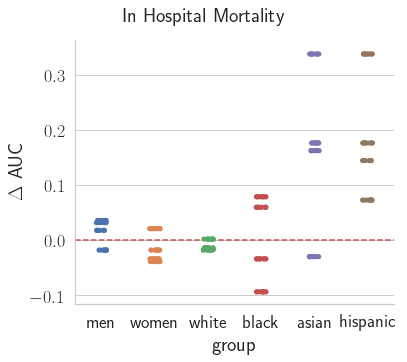

In [13]:
dataset="IHM"
dataset="mini-"+dataset
MODEL="CLINICALBERT-POOL"
OUTPUT_PATH=BASE_PATH+"/DATA/aftermath/"
Z = run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, 
             clear_results=False, tuning=False, metric=METRIC)
plot_analyses(OUTPUT_PATH, dataset, "In Hospital Mortality", MODEL, metric=METRIC)


******** In Hospital Mortality mini-IHM ********
[train/test set size: 1000/1000]
[running torch classifier]
[reading cached features]
skipped seed: 2201x2201
skipped seed: 2201x9325
skipped seed: 2201x1033
skipped seed: 2201x4179
skipped seed: 9325x2201
skipped seed: 9325x9325
skipped seed: 9325x1033
skipped seed: 9325x4179
skipped seed: 1033x2201
skipped seed: 1033x9325
skipped seed: 1033x1033
skipped seed: 1033x4179
skipped seed: 4179x2201
skipped seed: 4179x9325
skipped seed: 4179x1033
skipped seed: 4179x4179
******** Acute and unspecified renal failure mini-AAURF ********
[train/test set size: 1000/1000]
[running torch classifier]
[reading cached features]
skipped seed: 2201x2201
skipped seed: 2201x9325
skipped seed: 2201x1033
skipped seed: 2201x4179
skipped seed: 9325x2201
skipped seed: 9325x9325
skipped seed: 9325x1033
skipped seed: 9325x4179
skipped seed: 1033x2201
skipped seed: 1033x9325
skipped seed: 1033x1033
skipped seed: 1033x4179
skipped seed: 4179x2201
skipped seed: 4179

[train/test set size: 1000/1000]
[running torch classifier]
[reading cached features]
skipped seed: 2201x2201
skipped seed: 2201x9325
skipped seed: 2201x1033
skipped seed: 2201x4179
skipped seed: 9325x2201
skipped seed: 9325x9325
skipped seed: 9325x1033
skipped seed: 9325x4179
skipped seed: 1033x2201
skipped seed: 1033x9325
skipped seed: 1033x1033
skipped seed: 1033x4179
skipped seed: 4179x2201
skipped seed: 4179x9325
skipped seed: 4179x1033
skipped seed: 4179x4179
******** Hypertension with complications and secondary hypertension mini-HWCASH ********
[train/test set size: 1000/1000]
[running torch classifier]
[reading cached features]
skipped seed: 2201x2201
skipped seed: 2201x9325
skipped seed: 2201x1033
skipped seed: 2201x4179
skipped seed: 9325x2201
skipped seed: 9325x9325
skipped seed: 9325x1033
skipped seed: 9325x4179
skipped seed: 1033x2201
skipped seed: 1033x9325
skipped seed: 1033x1033
skipped seed: 1033x4179
skipped seed: 4179x2201
skipped seed: 4179x9325
skipped seed: 4179x

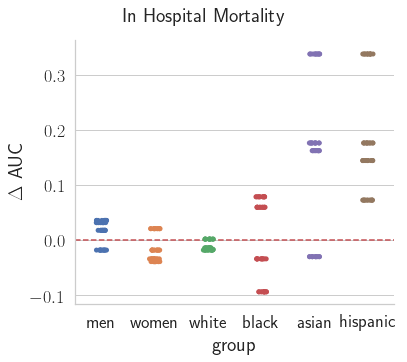

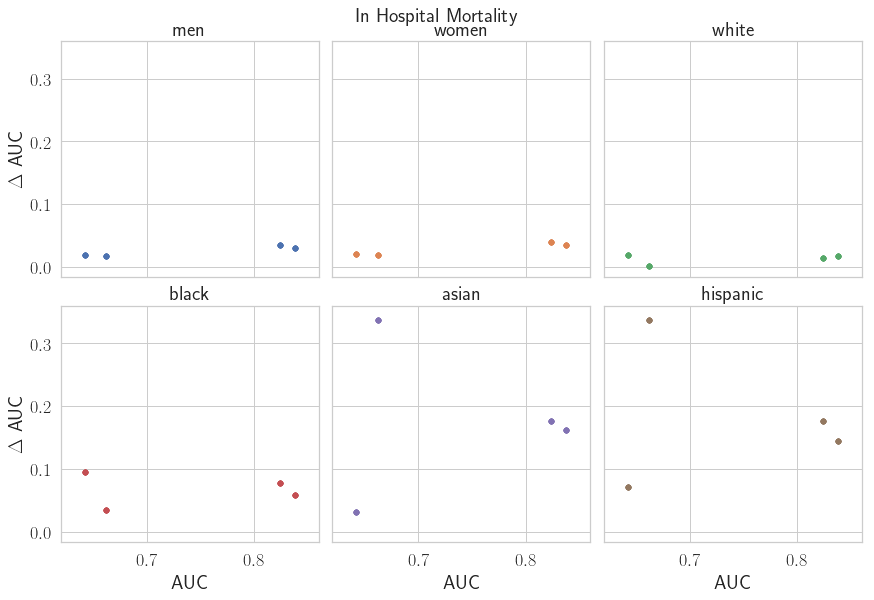

['ihm', 'aaurf']


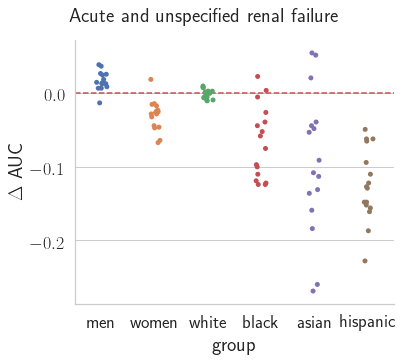

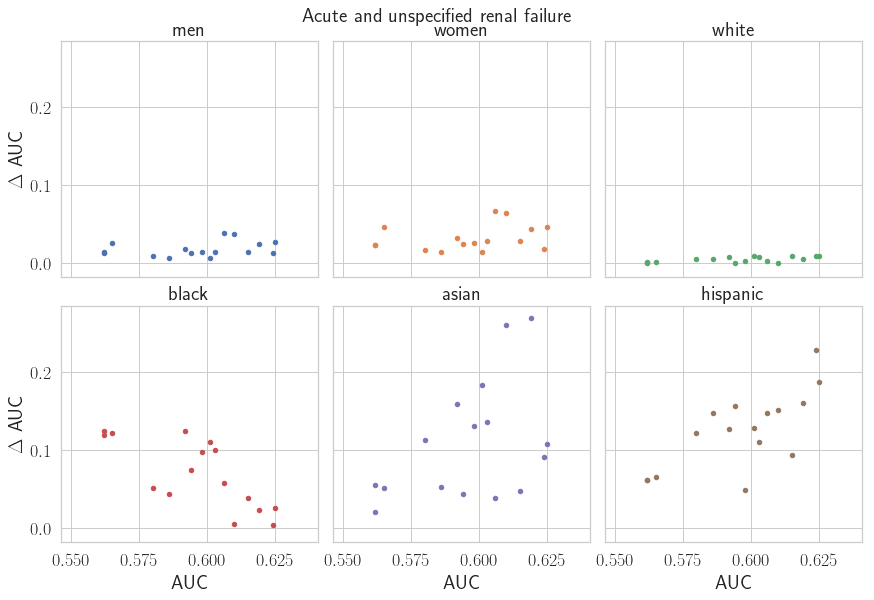

['ihm', 'aaurf', 'acd']


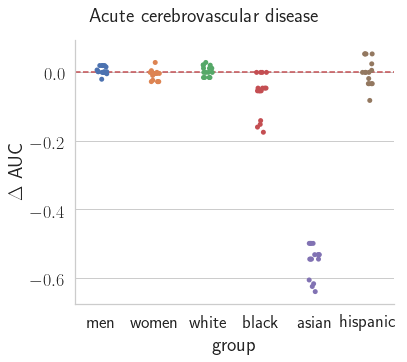

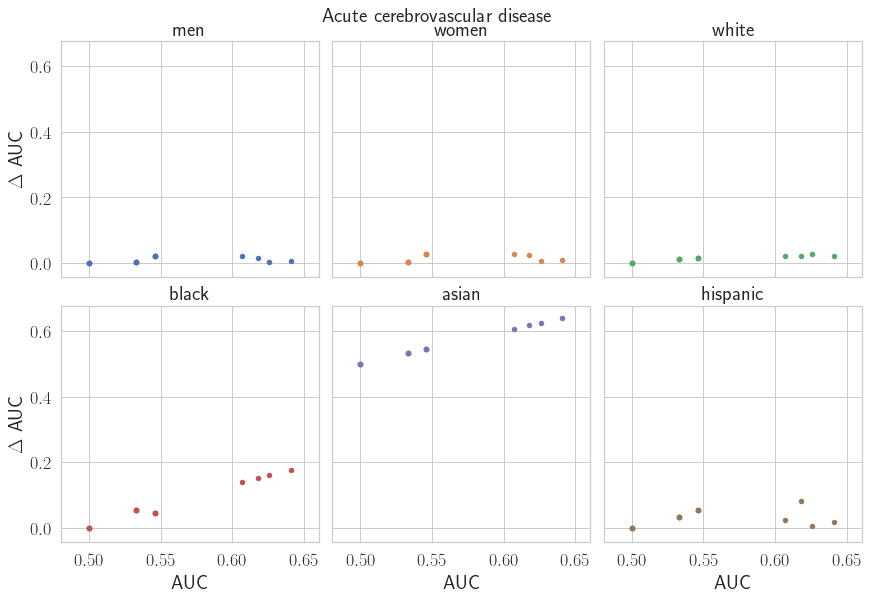

['ihm', 'aaurf', 'acd', 'ami']


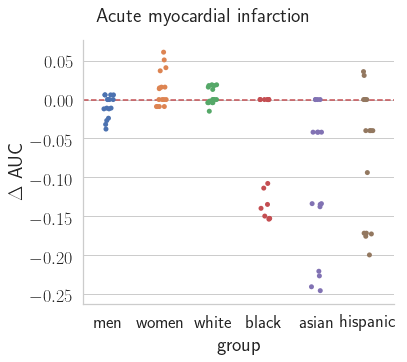

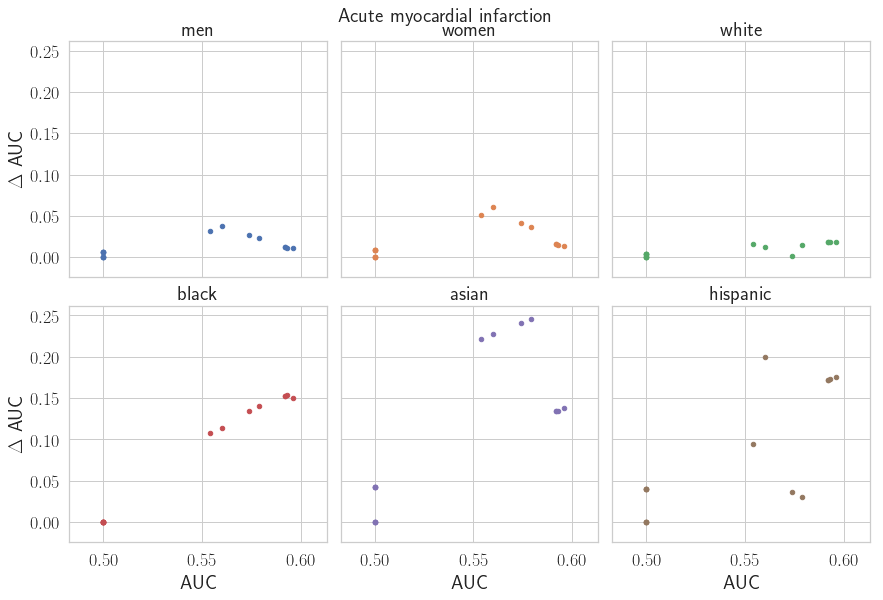

['ihm', 'aaurf', 'acd', 'ami', 'cd']


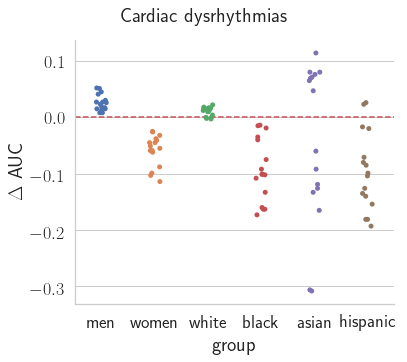

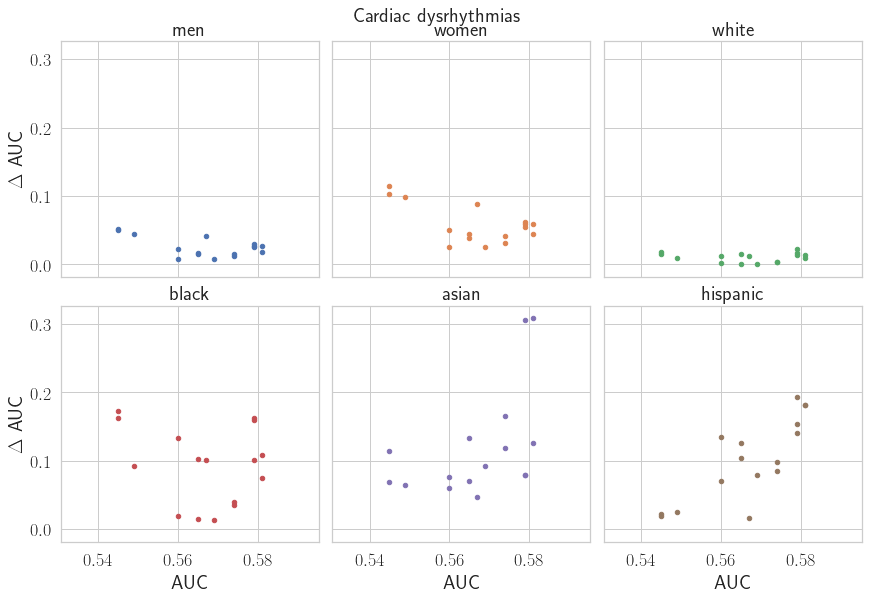

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd']


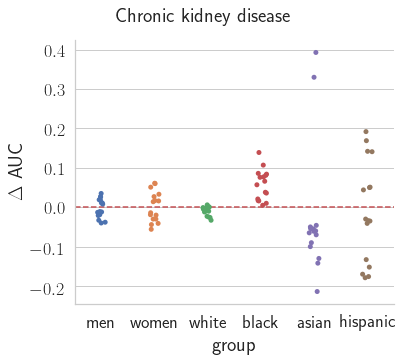

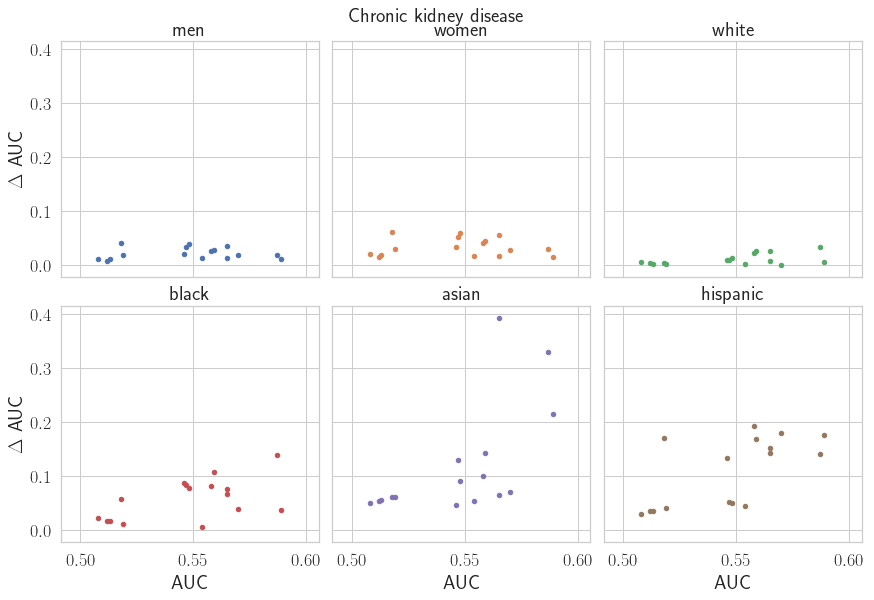

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab']


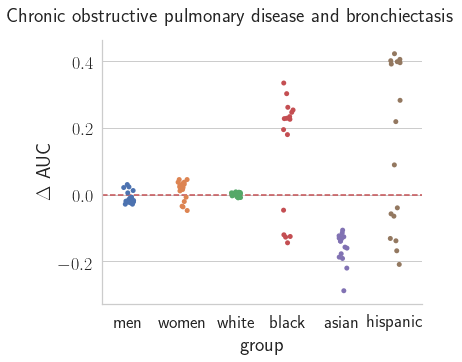

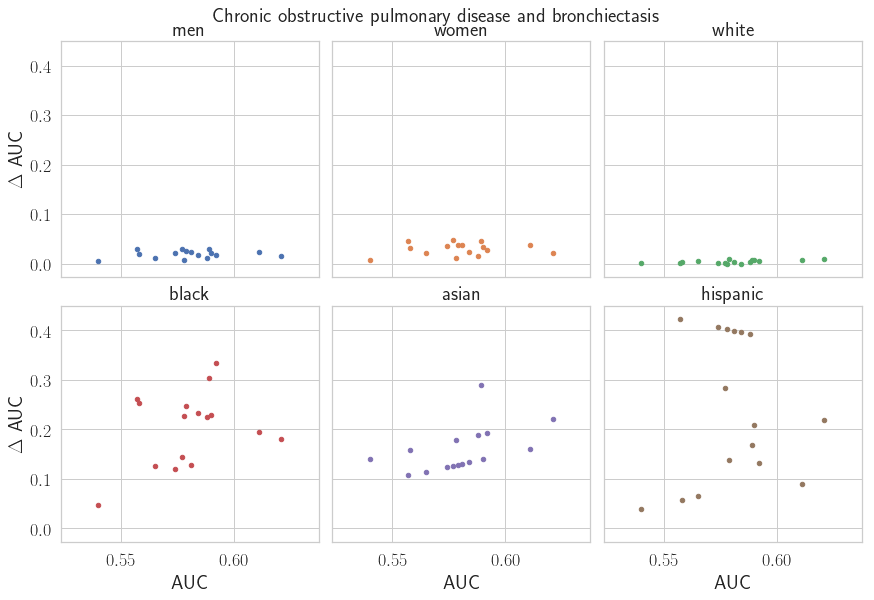

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc']


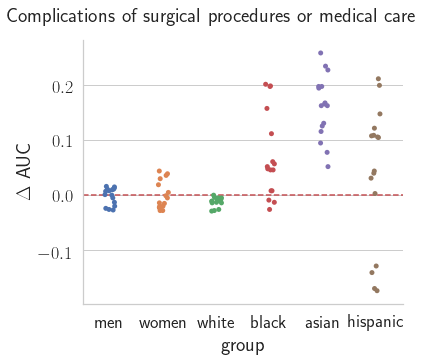

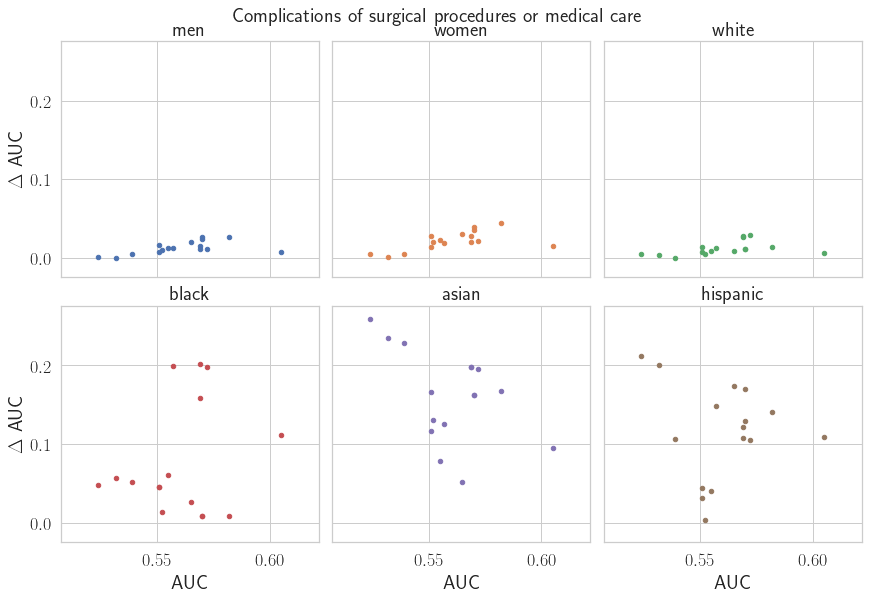

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2']


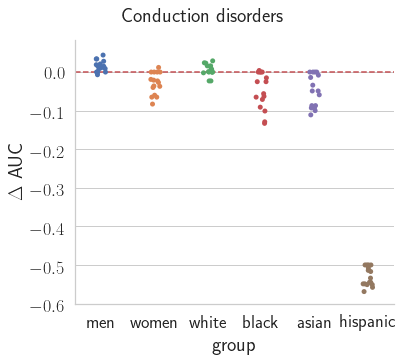

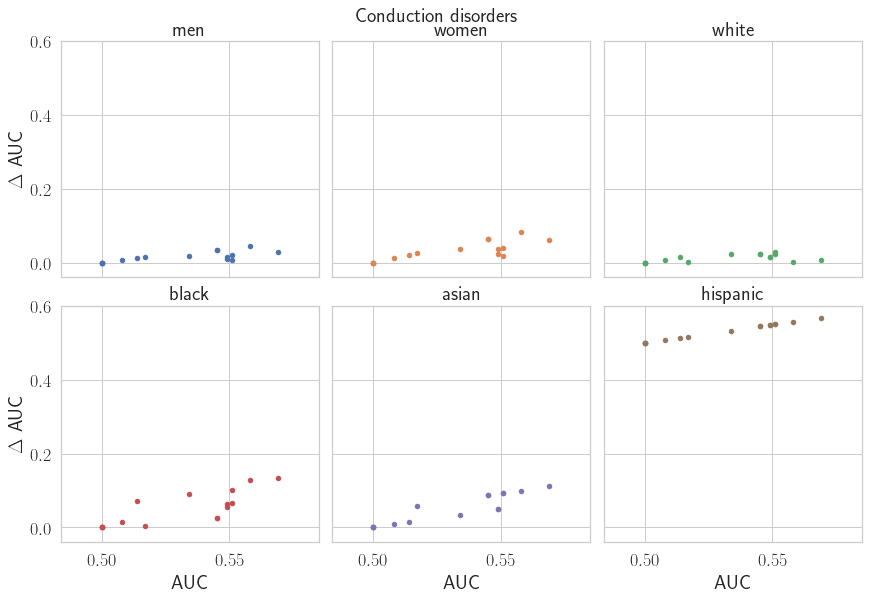

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn']


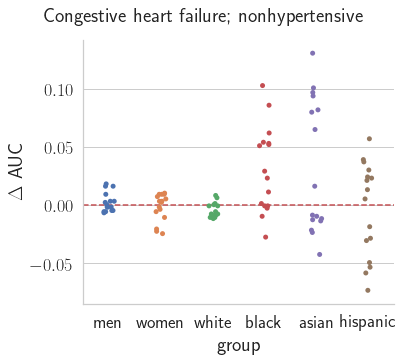

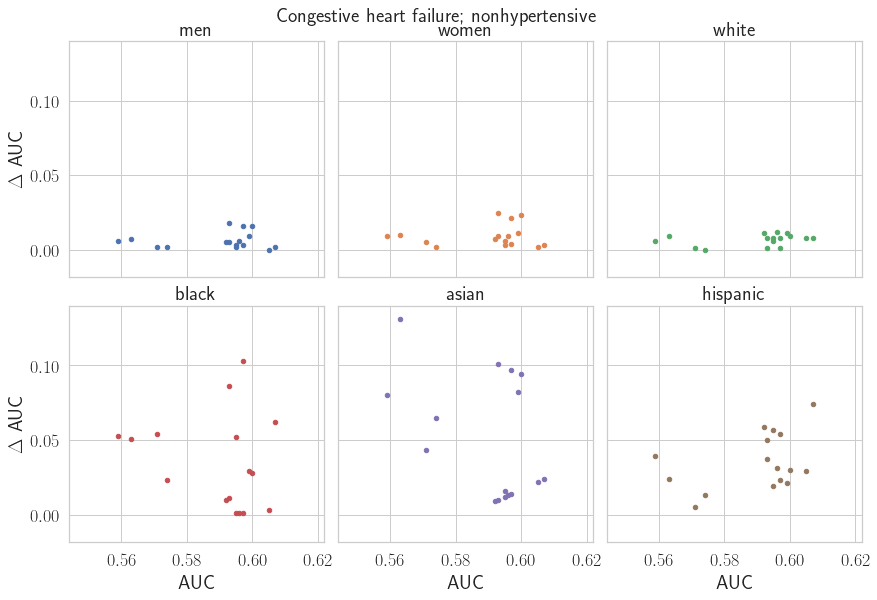

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd']


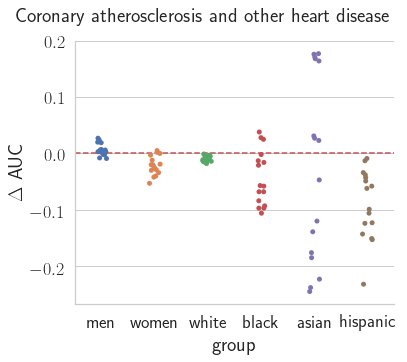

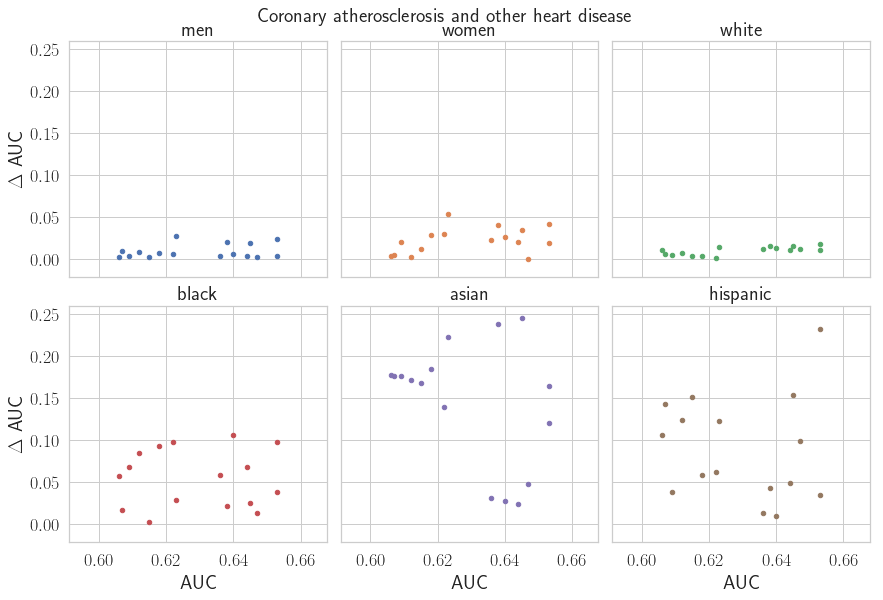

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc']


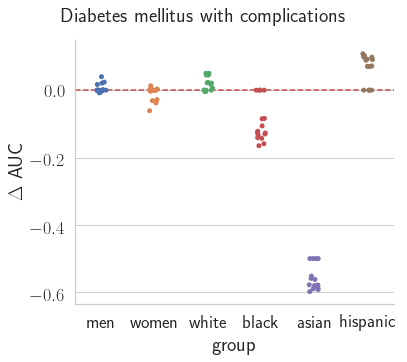

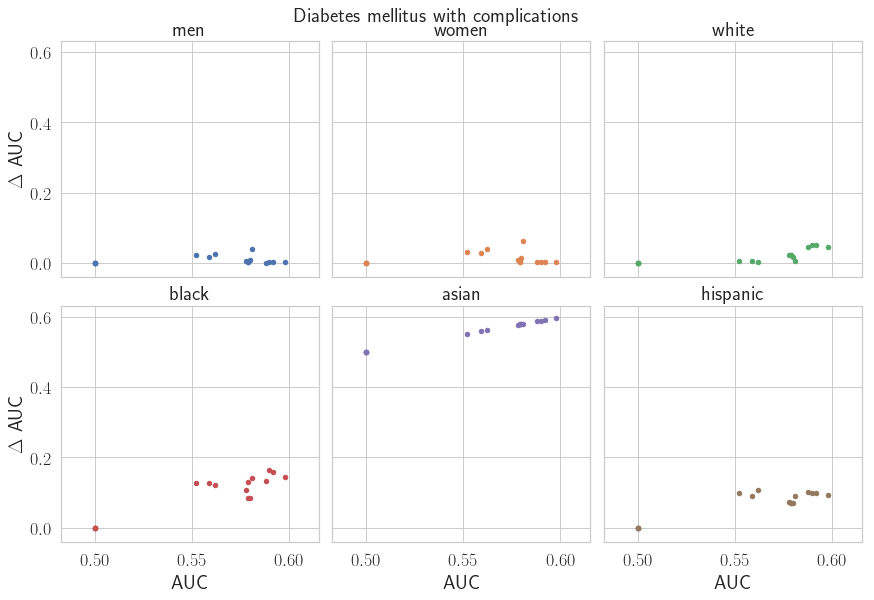

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2']


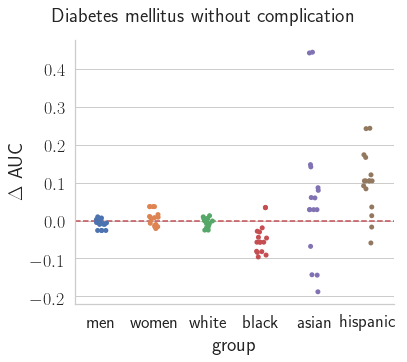

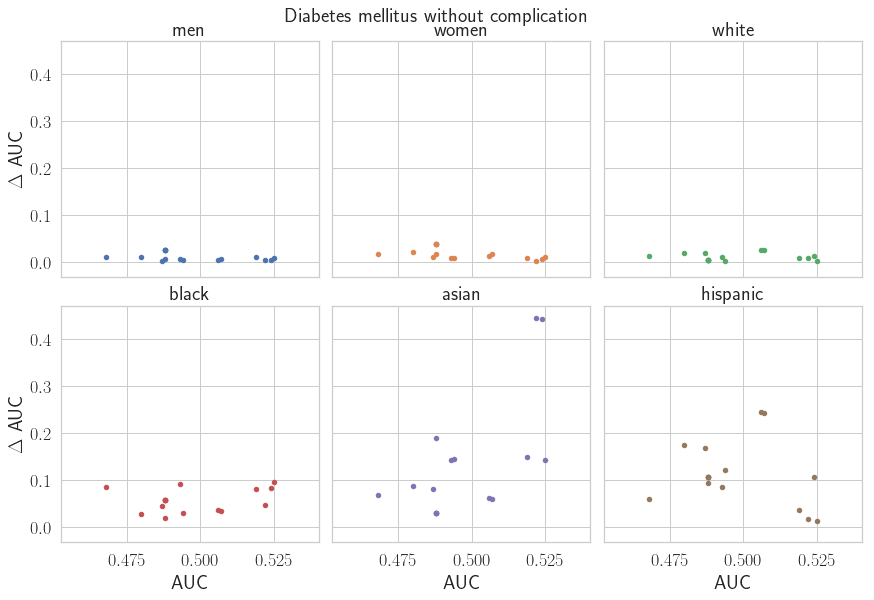

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm']


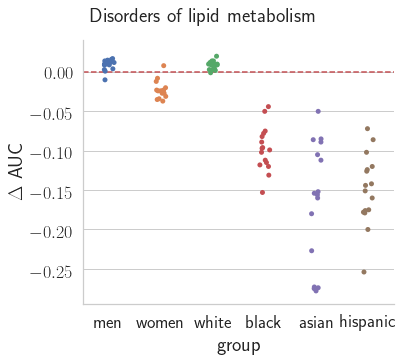

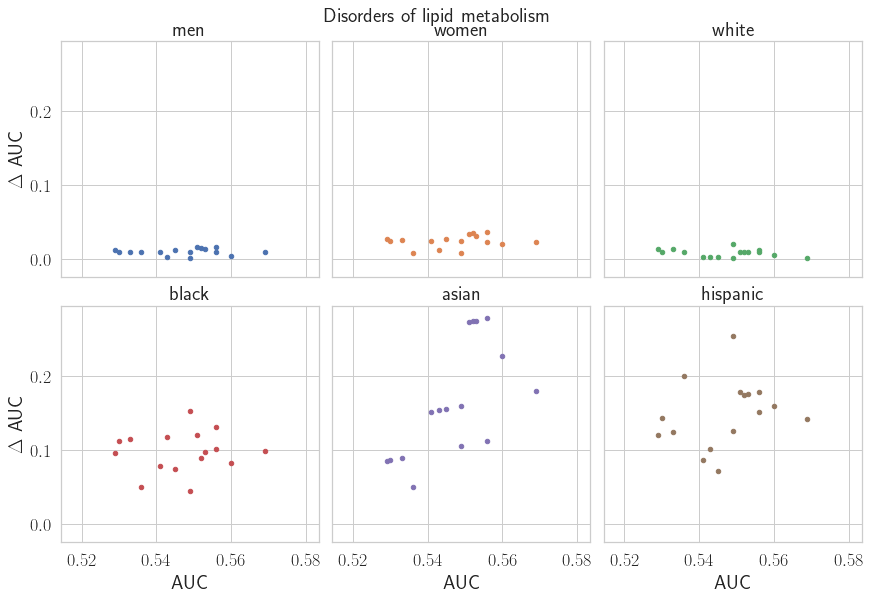

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh']


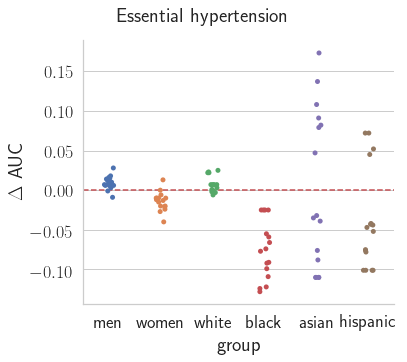

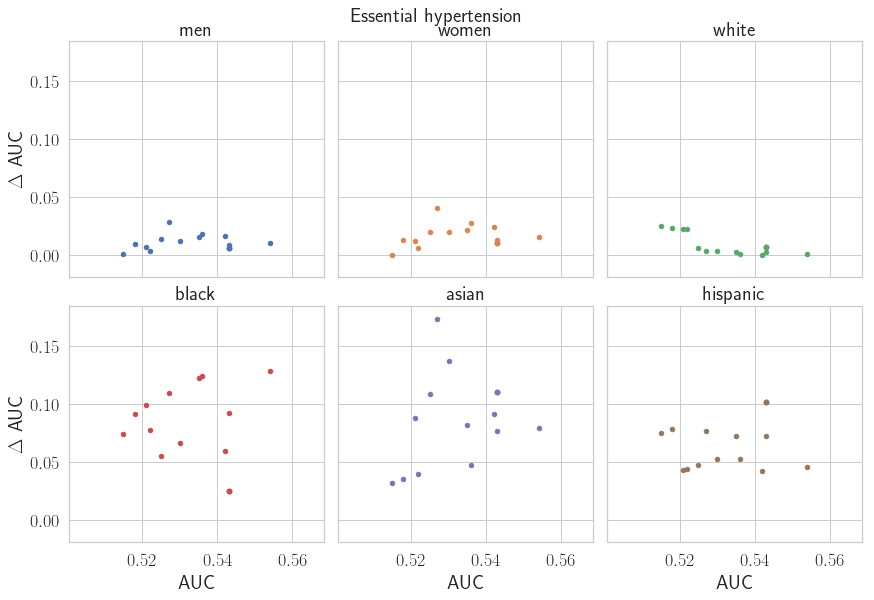

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed']


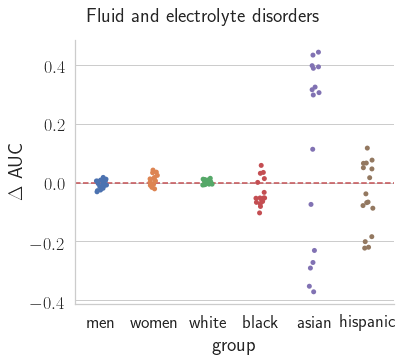

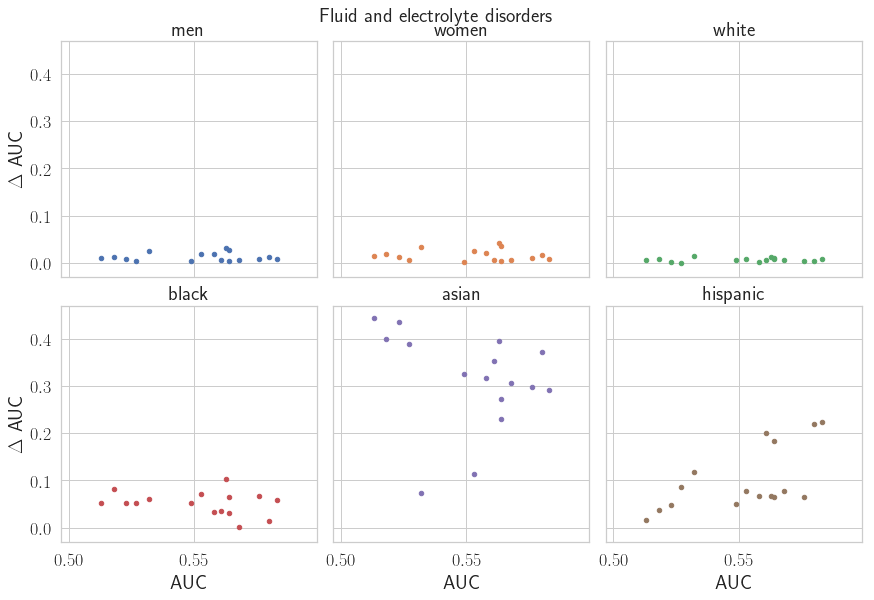

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh']


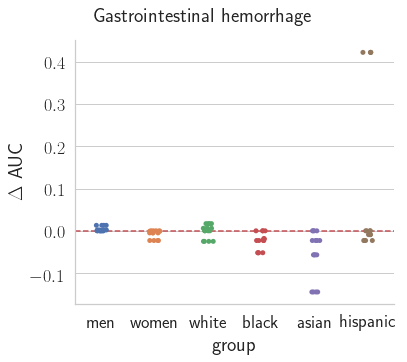

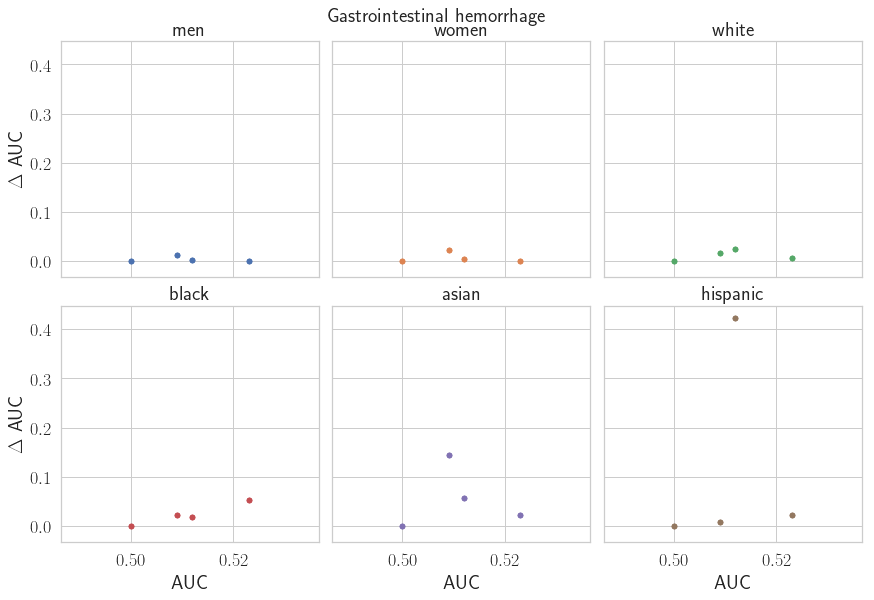

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash']


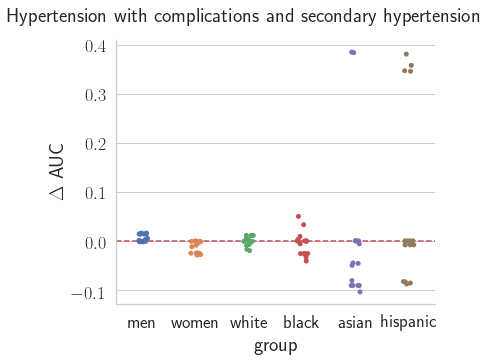

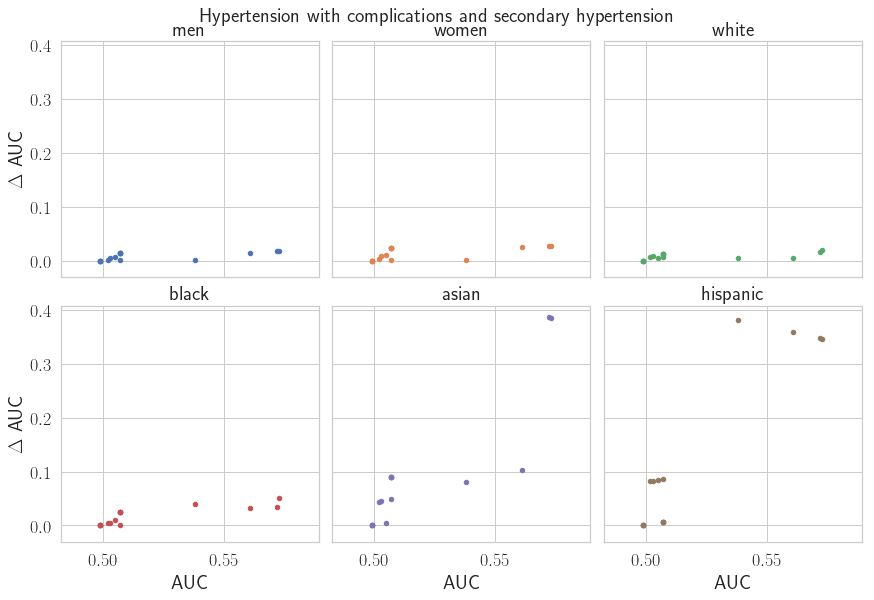

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old']


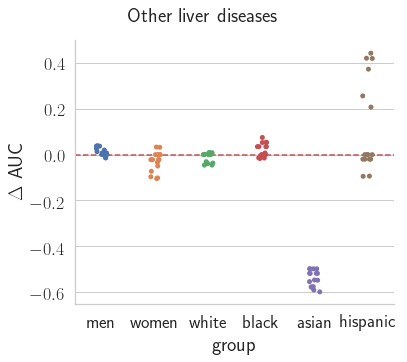

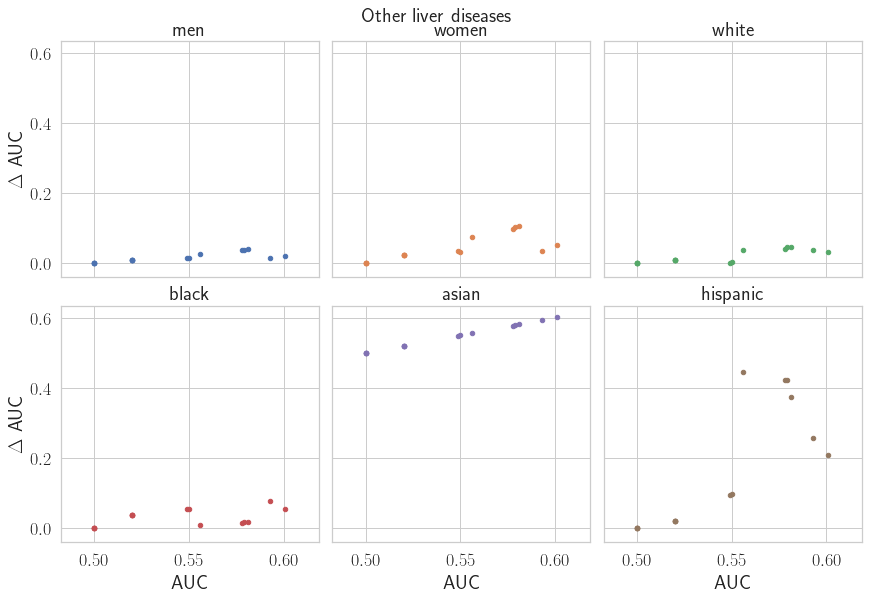

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd']


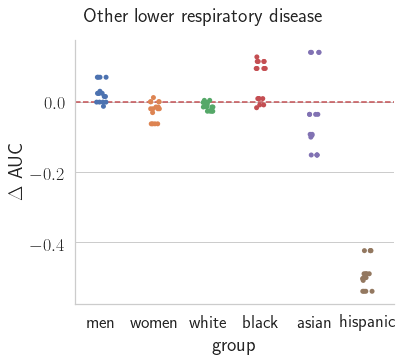

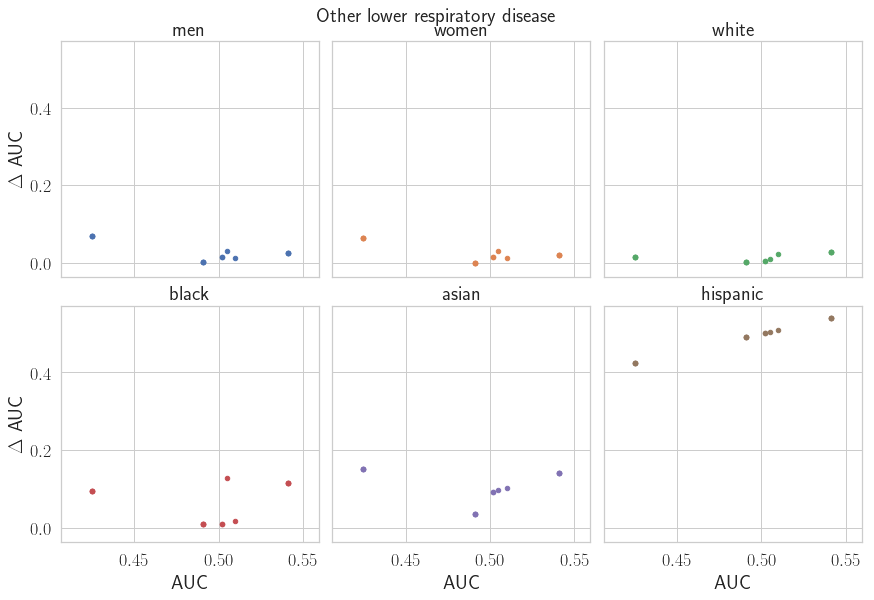

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd']


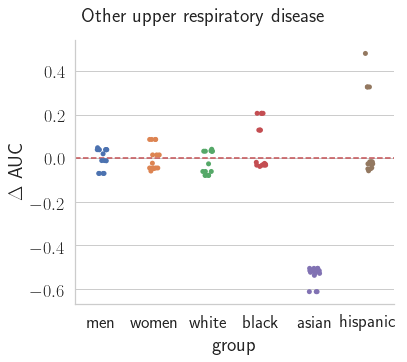

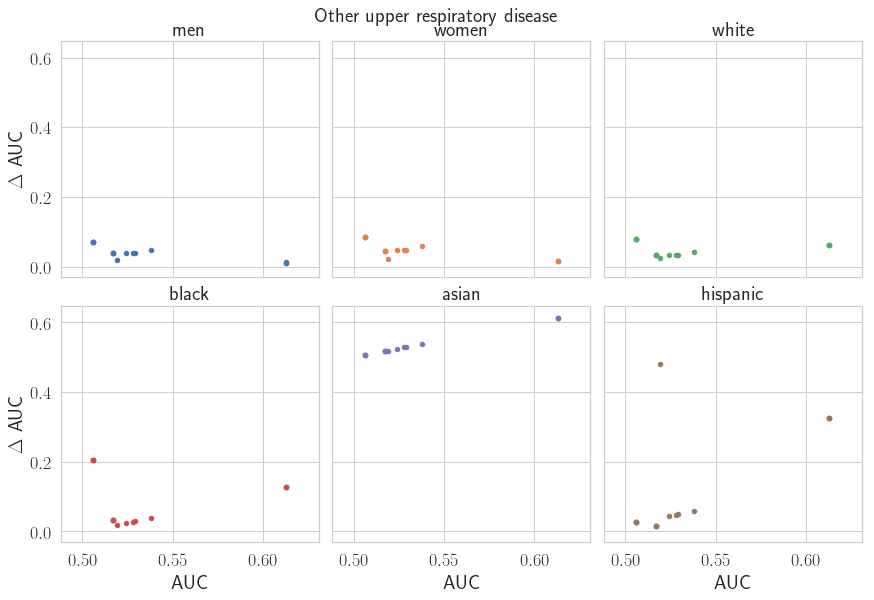

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc']


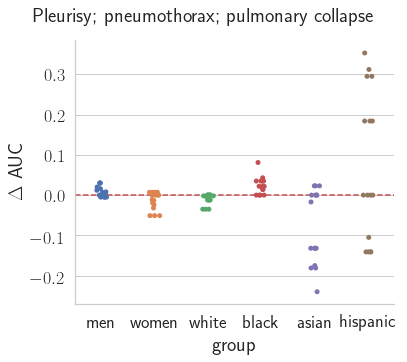

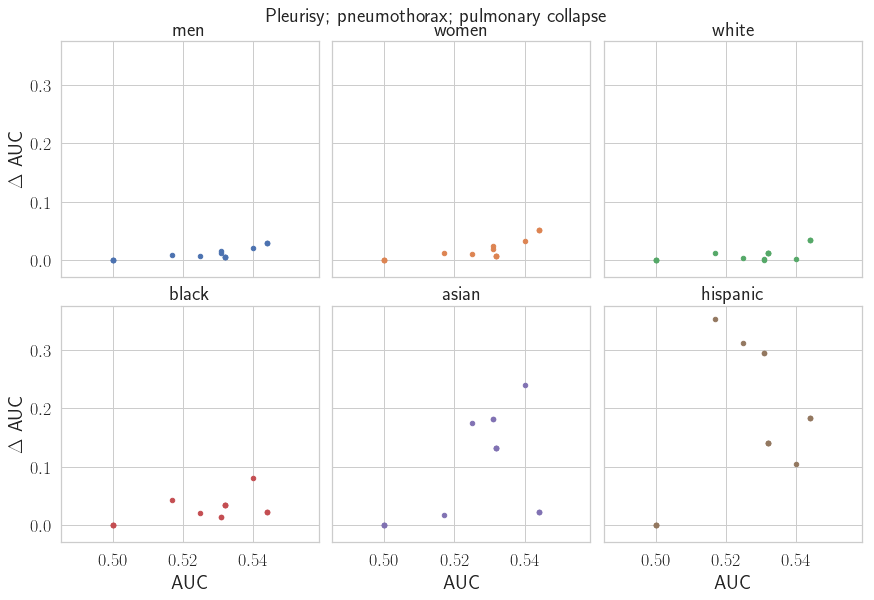

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc', 'ptcbtostd']


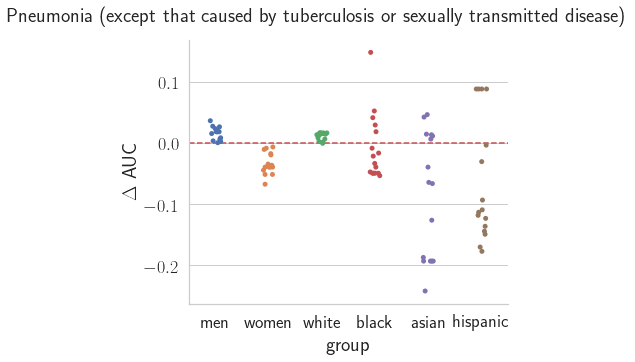

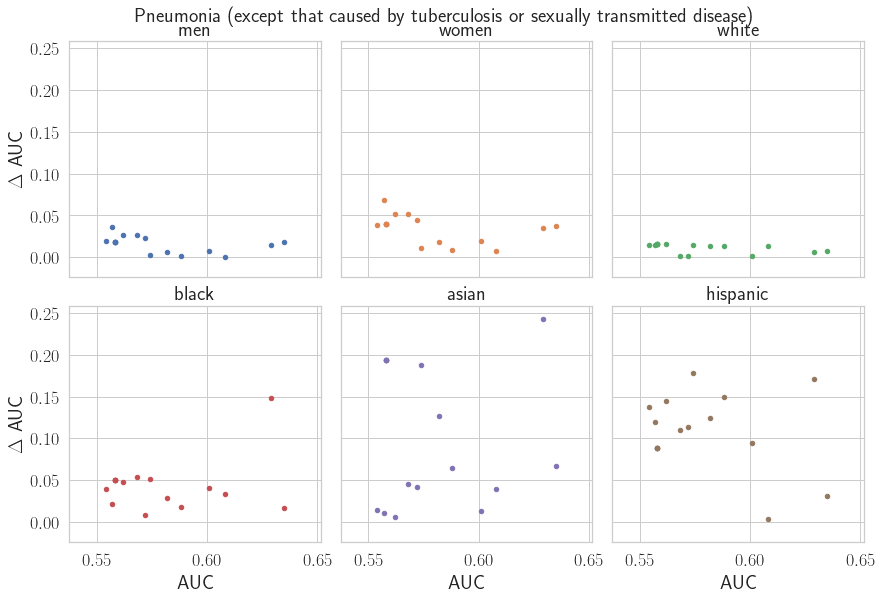

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc', 'ptcbtostd', 'rfia']


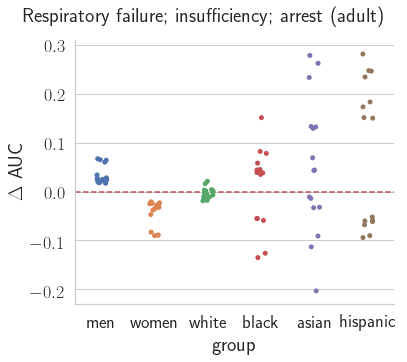

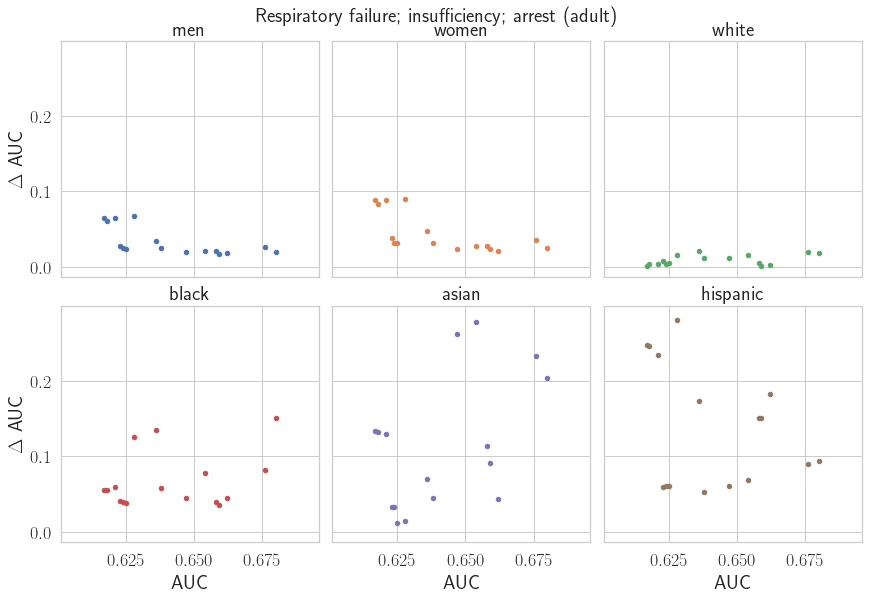

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc', 'ptcbtostd', 'rfia', 'sil']


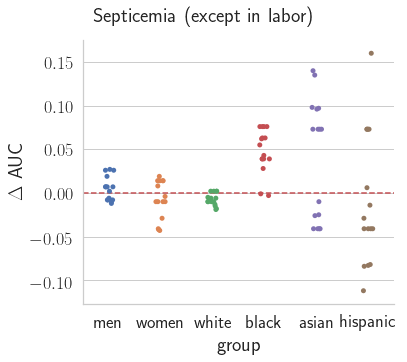

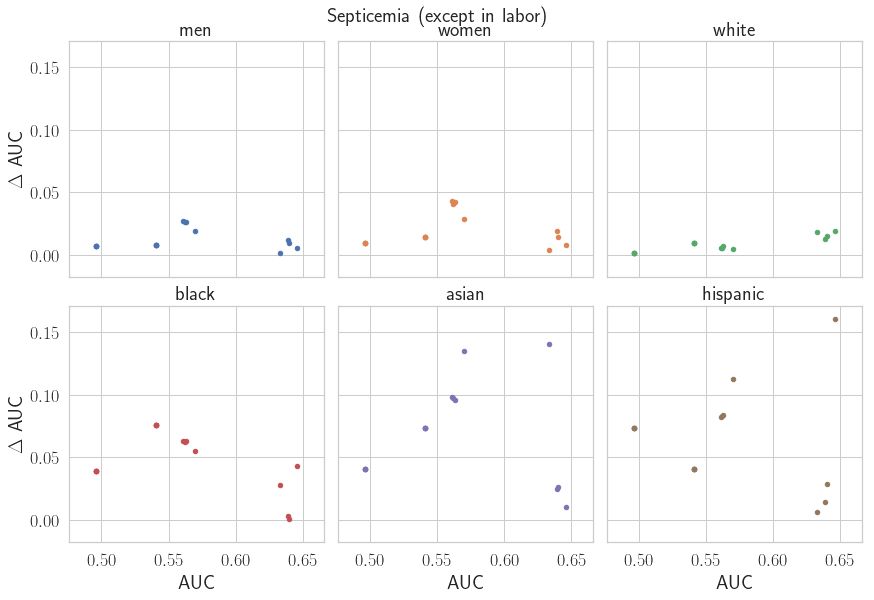

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc', 'ptcbtostd', 'rfia', 'sil', 's']


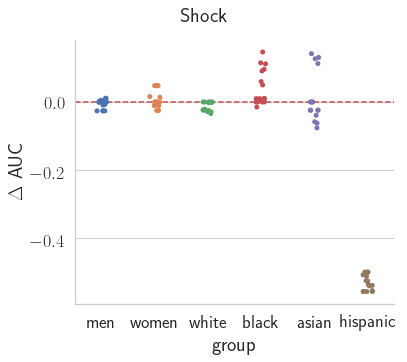

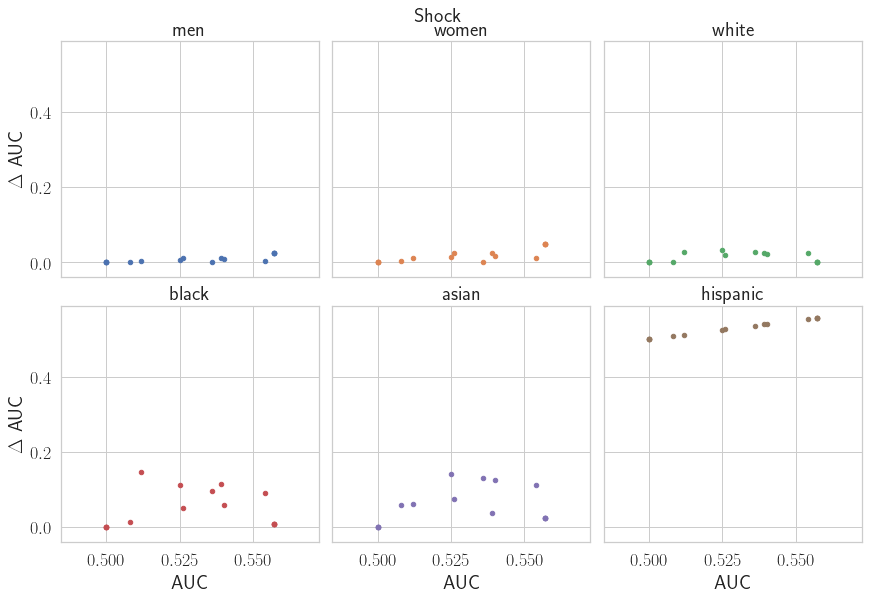

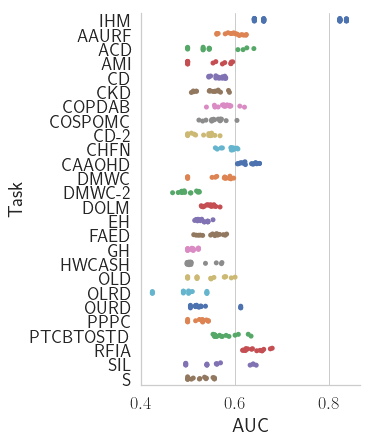

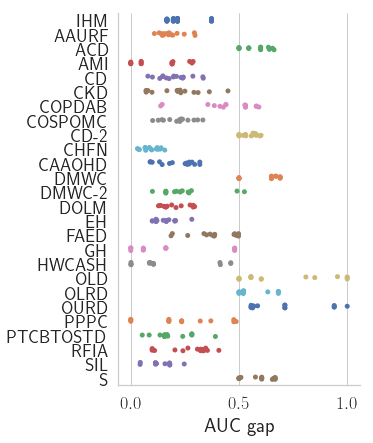

<Figure size 432x288 with 0 Axes>

In [14]:
OUTPUT_PATH=BASE_PATH+"/DATA/aftermath/"
#Run tasks
CLASSIFIER="torch"
MODEL="CLINICALBERT-POOL"
run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, reset=True, 
            metric=METRIC, tuning=False, mini_tasks=True)
plot_tasks(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=True,  metric=METRIC)
plot_summary(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=True,  metric=METRIC)

['ihm']


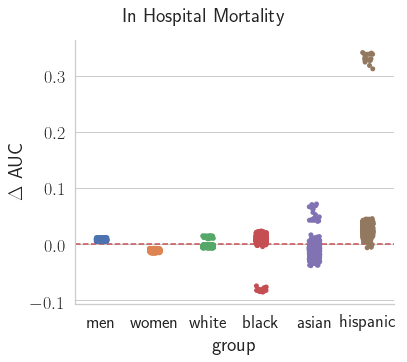

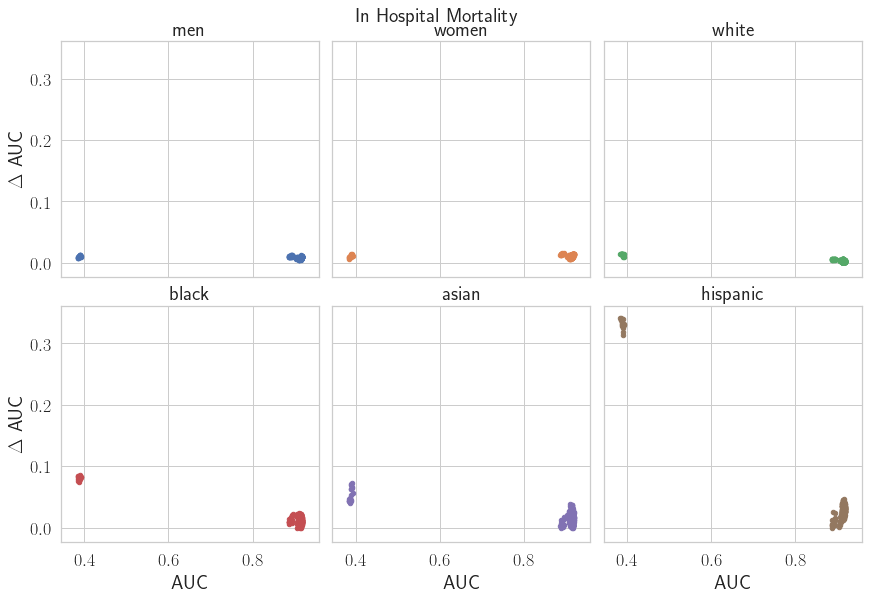

['ihm', 'aaurf']


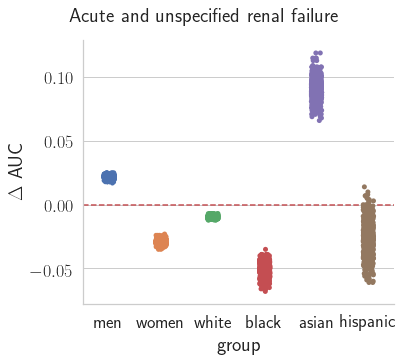

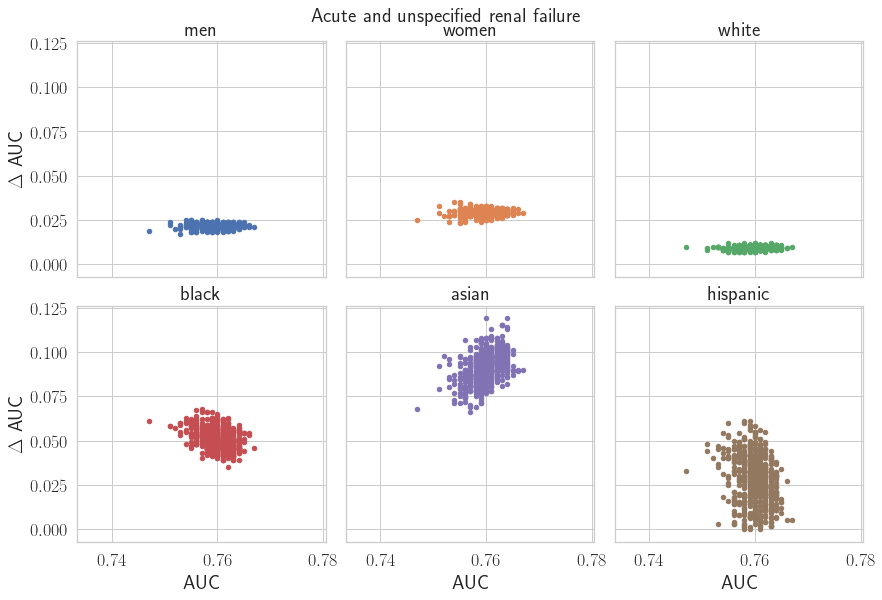

['ihm', 'aaurf', 'acd']


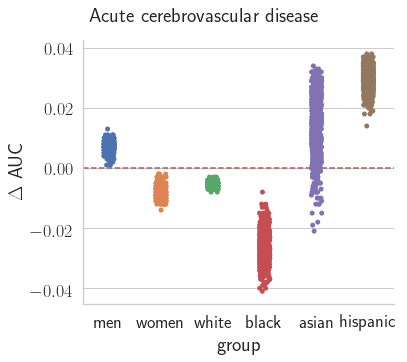

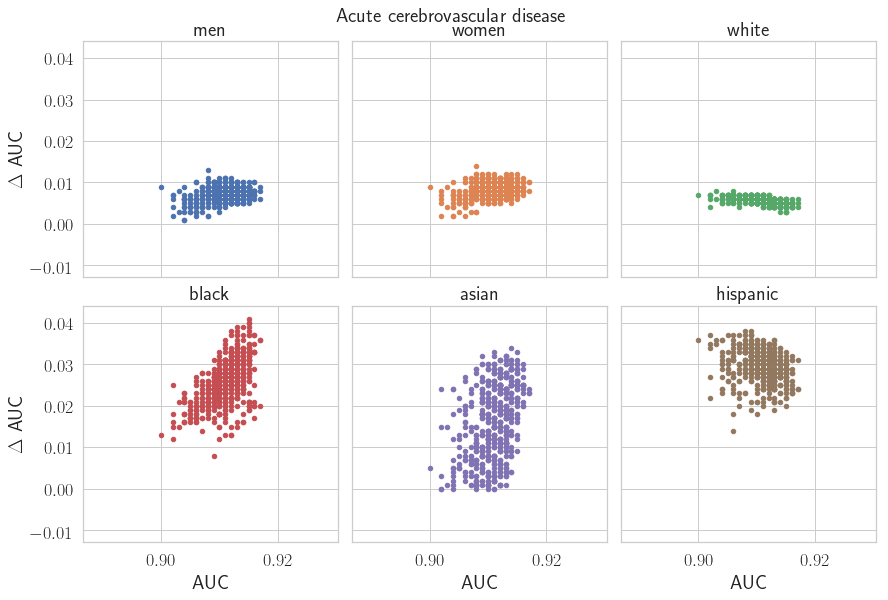

['ihm', 'aaurf', 'acd', 'ami']


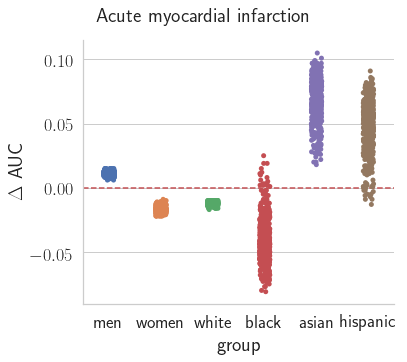

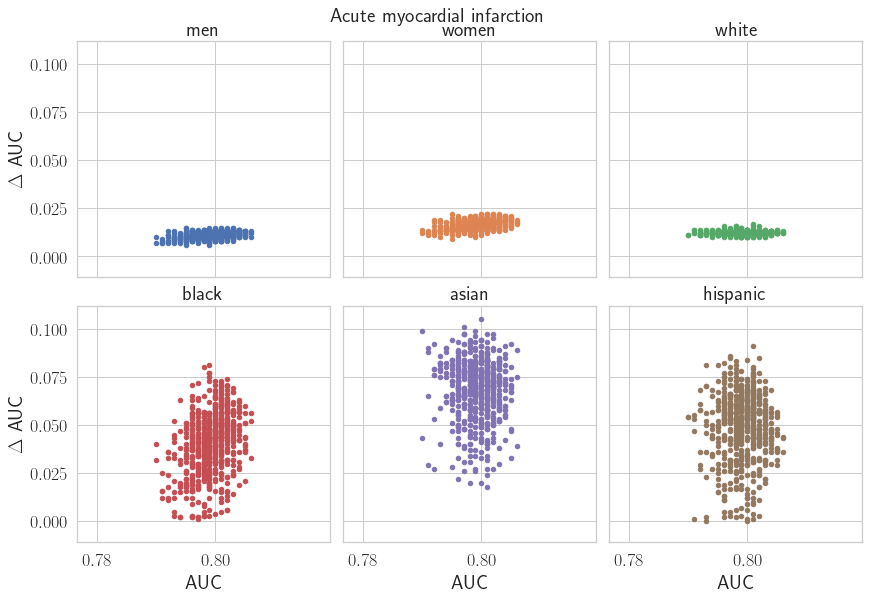

['ihm', 'aaurf', 'acd', 'ami', 'cd']


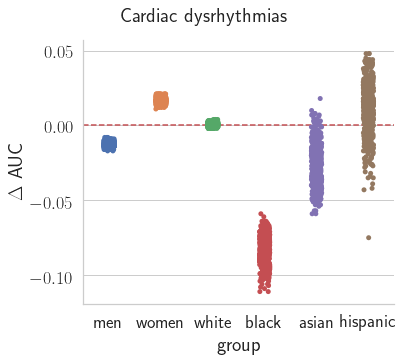

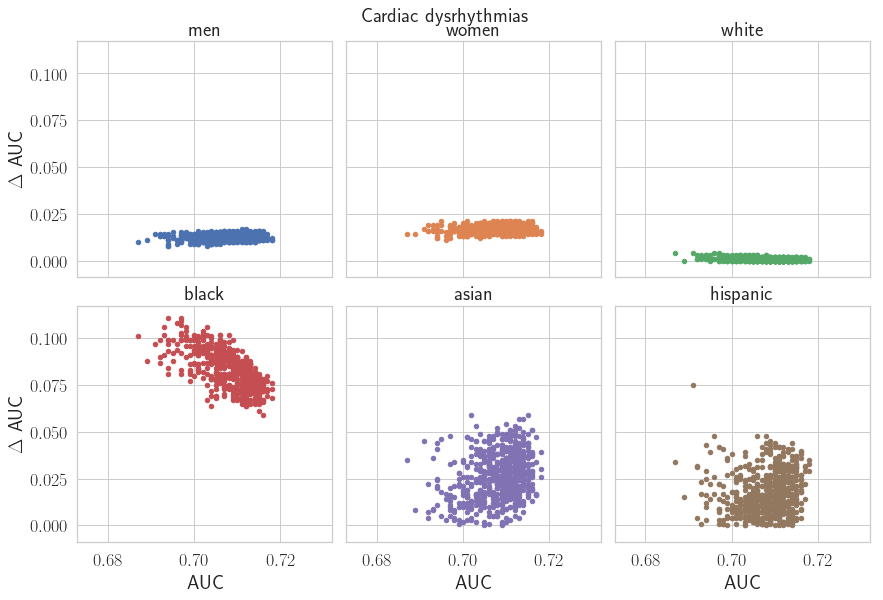

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd']


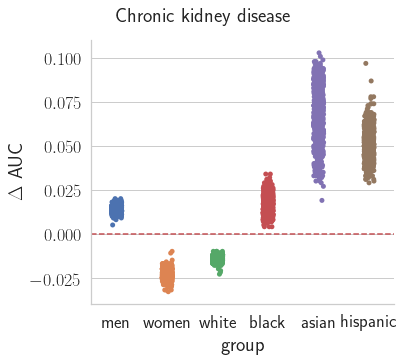

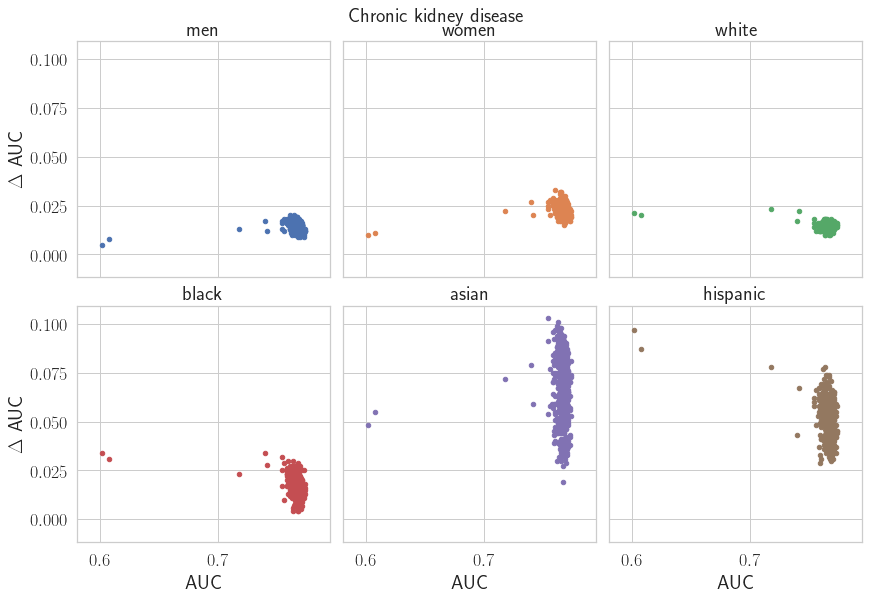

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab']


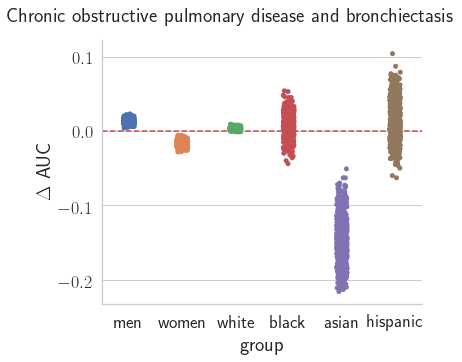

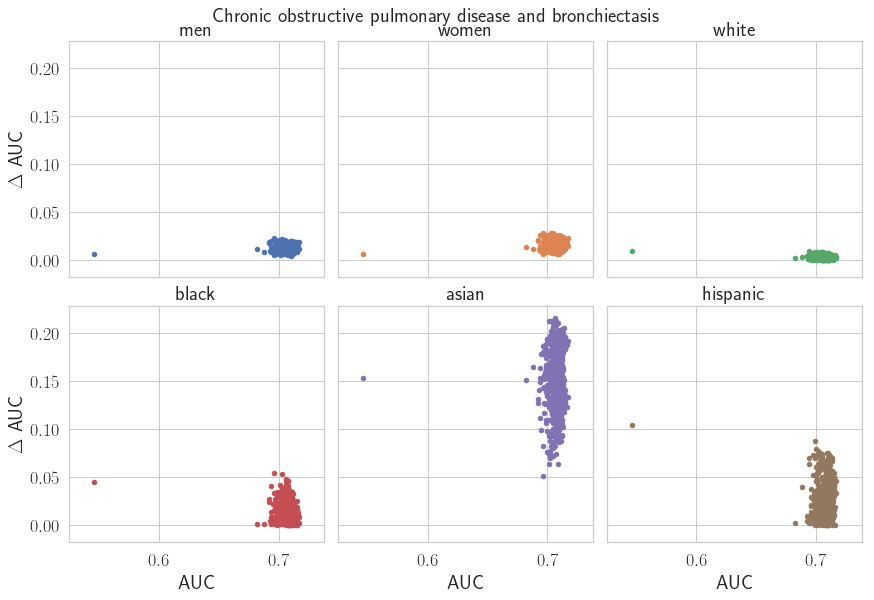

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc']


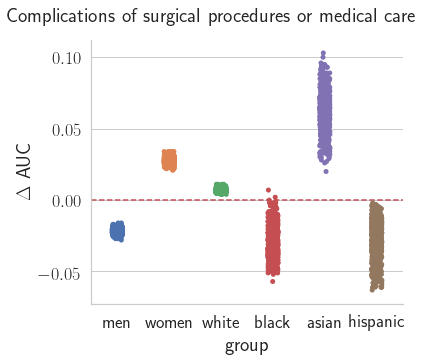

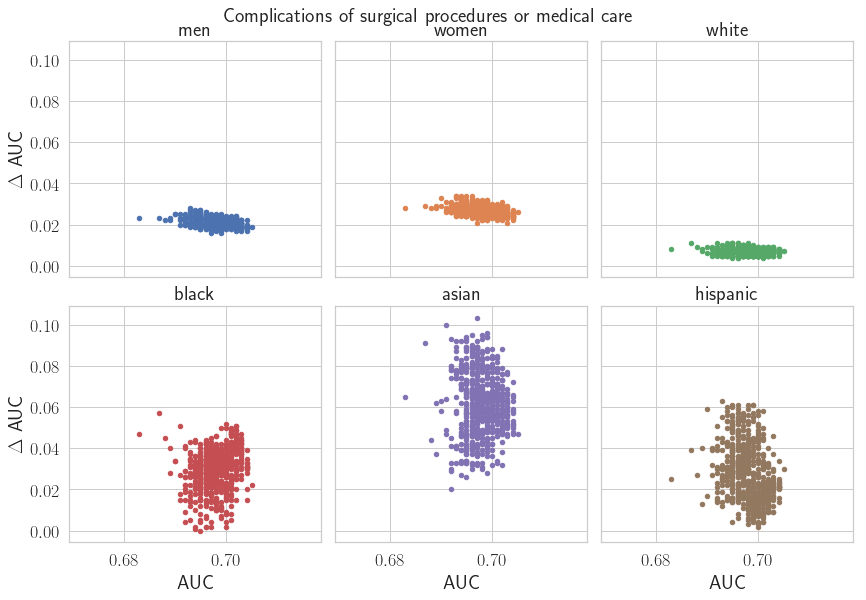

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2']


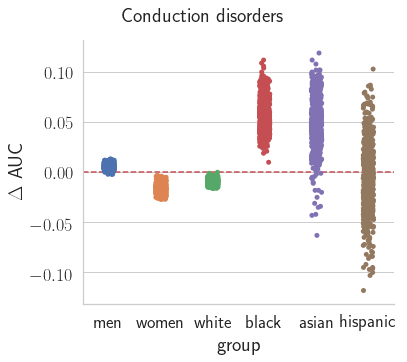

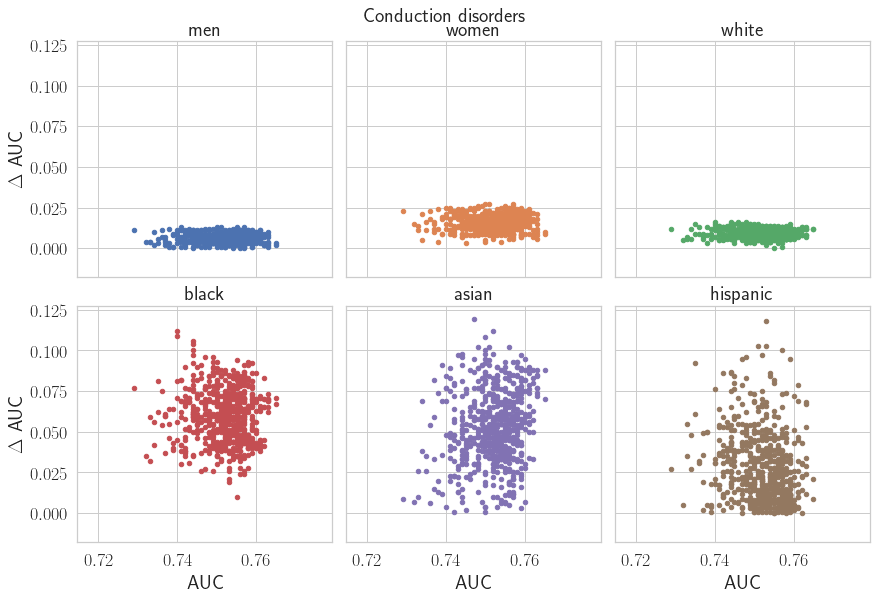

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn']


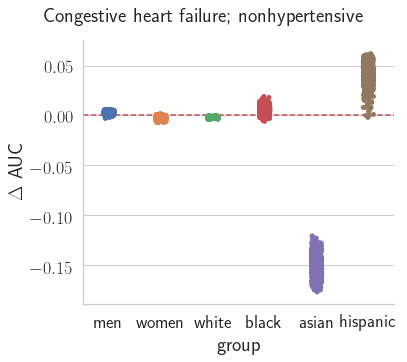

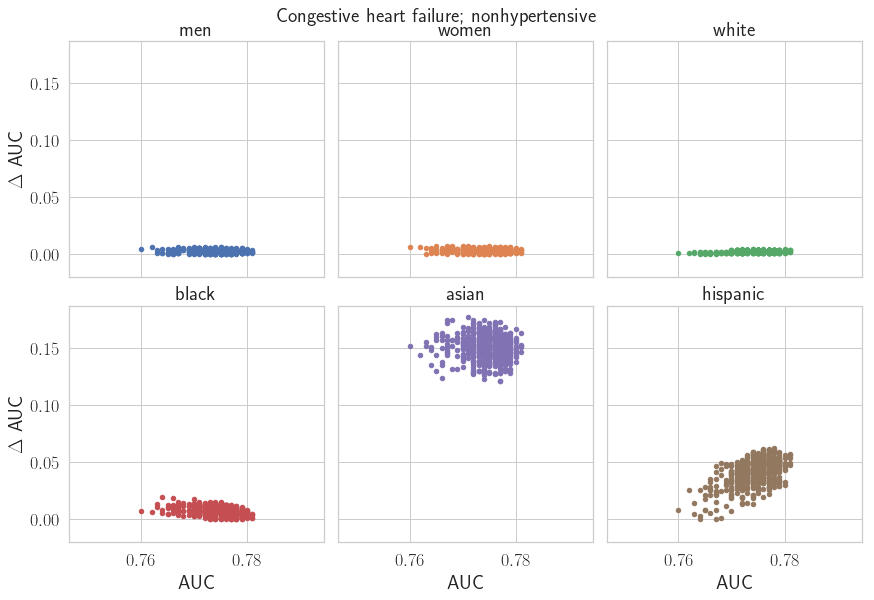

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd']


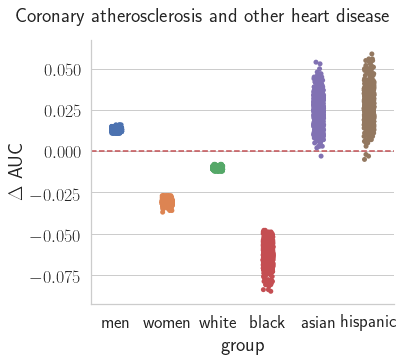

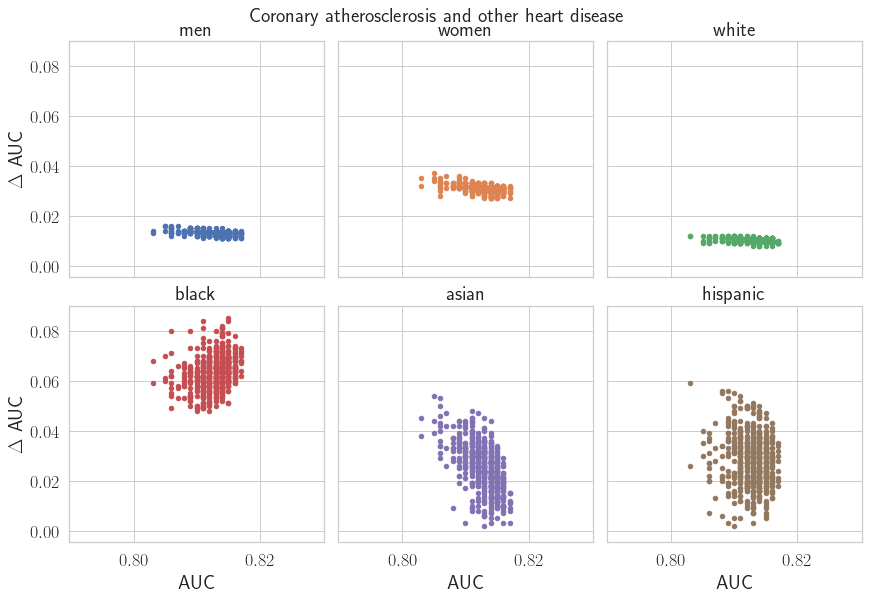

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc']


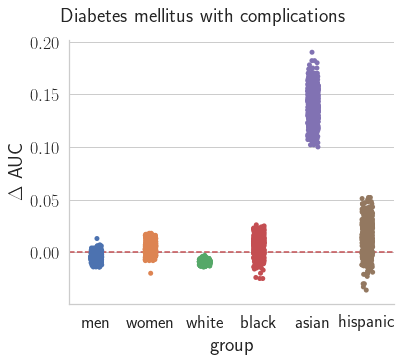

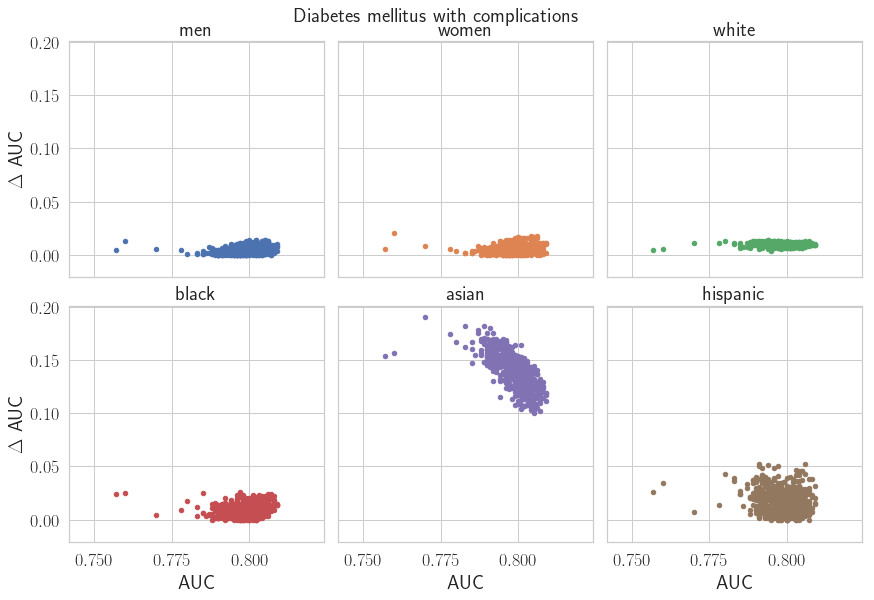

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2']


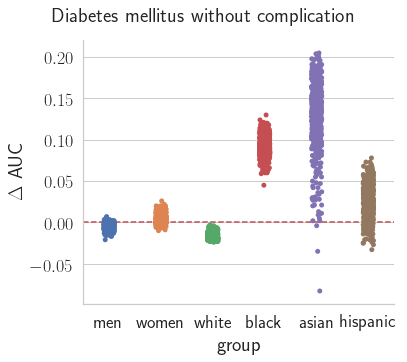

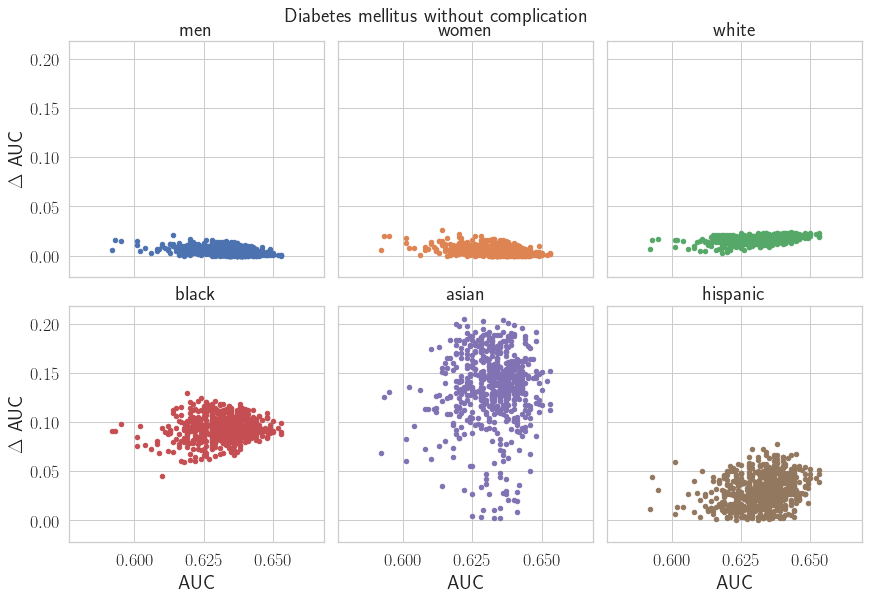

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm']
dolm_clinicalmulti-bert-pool_auroc.csv not found...
['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh']


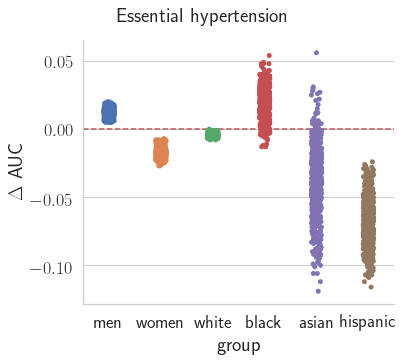

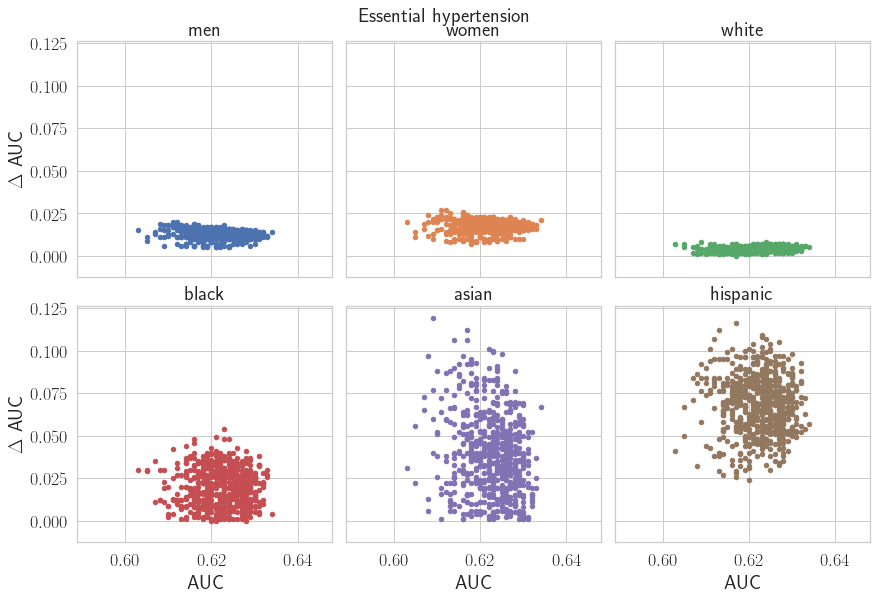

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed']


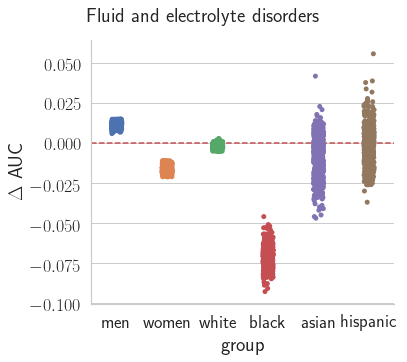

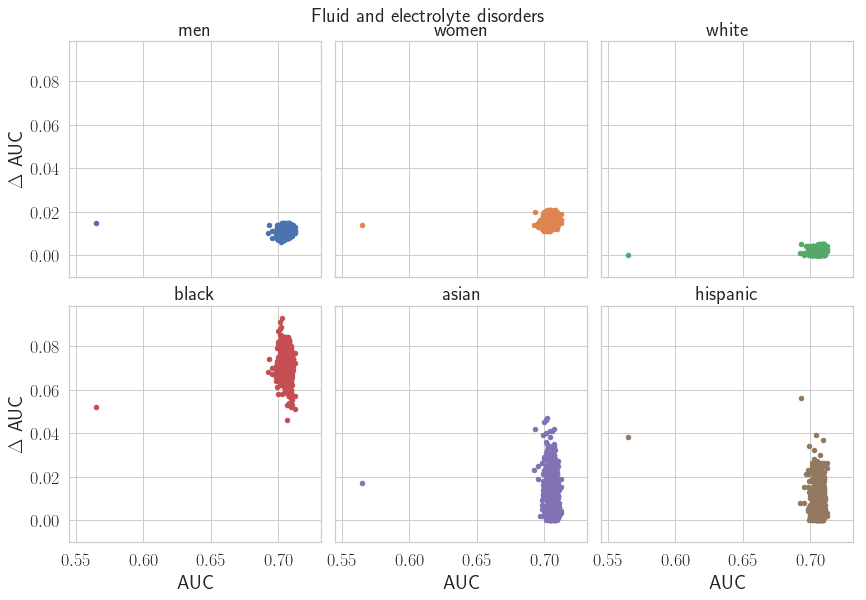

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh']


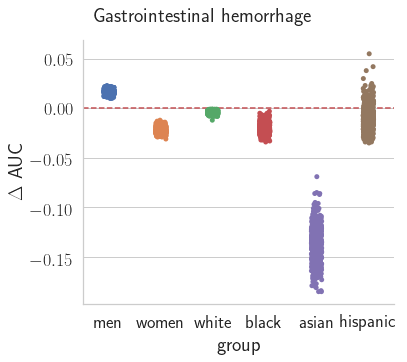

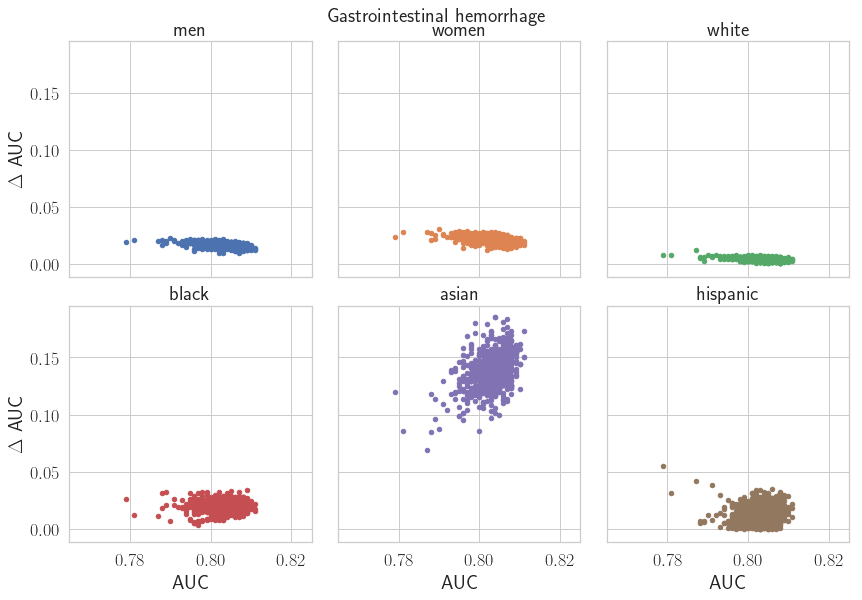

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash']


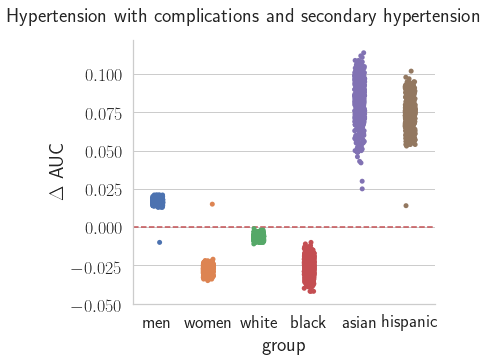

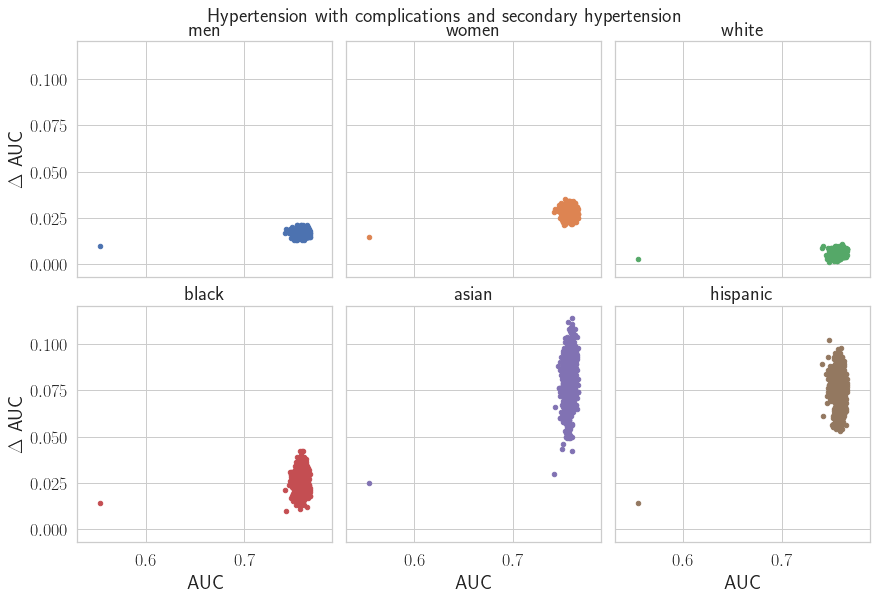

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old']


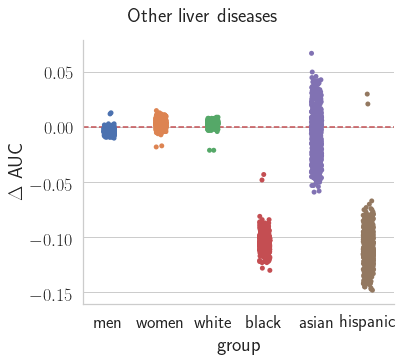

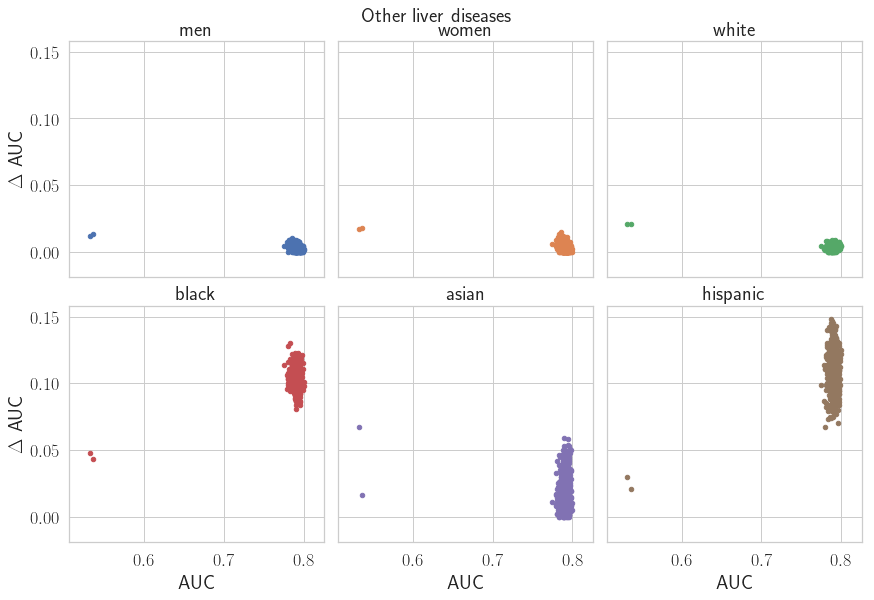

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd']


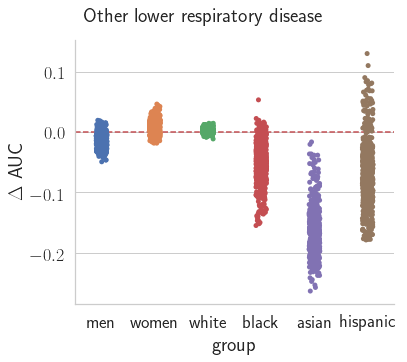

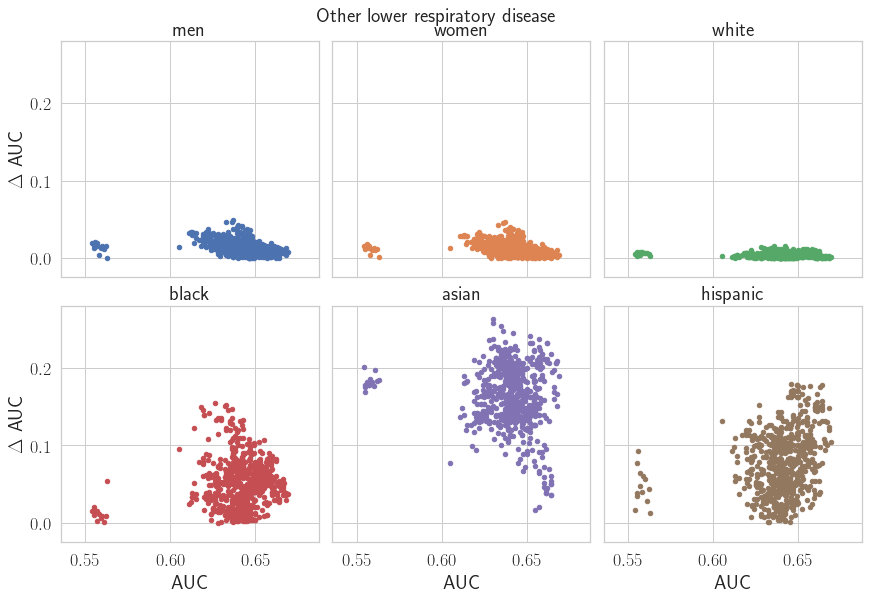

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd']


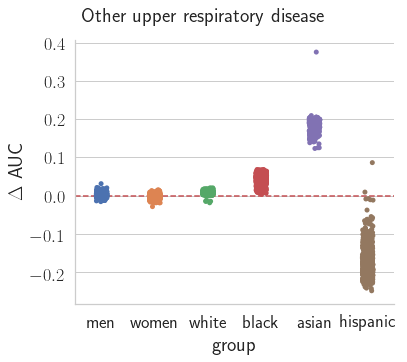

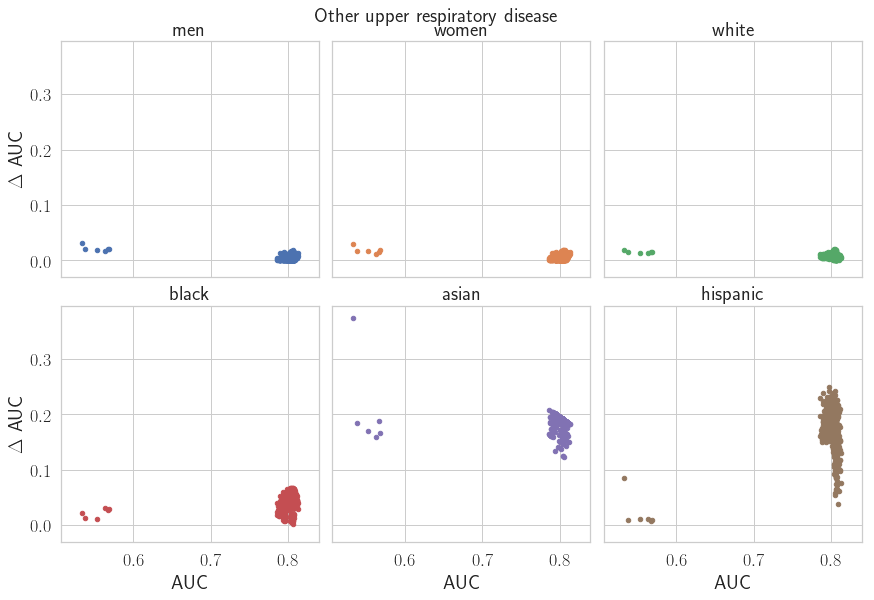

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc']


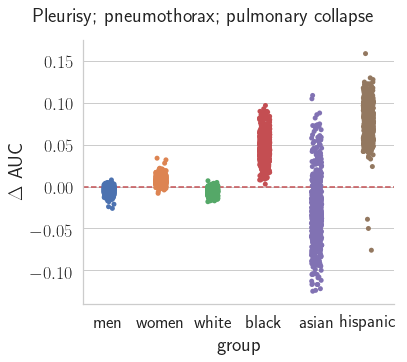

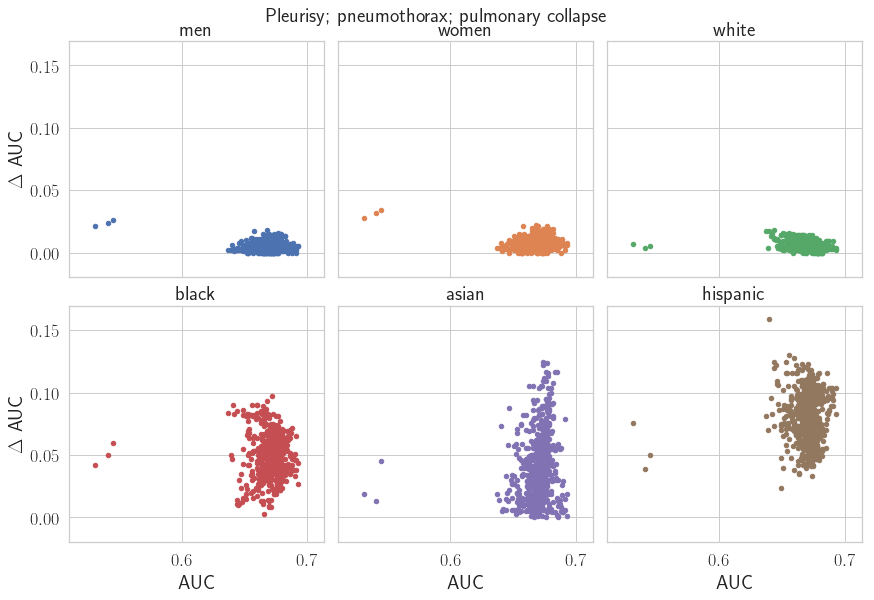

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc', 'ptcbtostd']


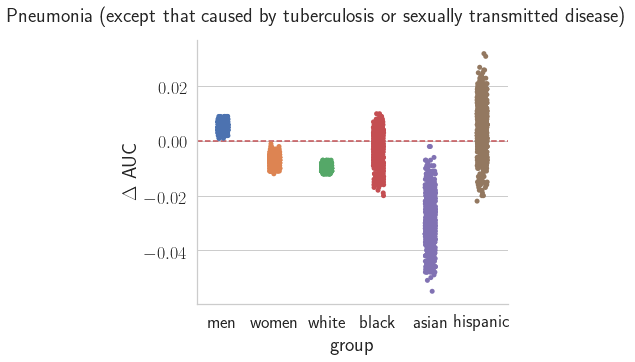

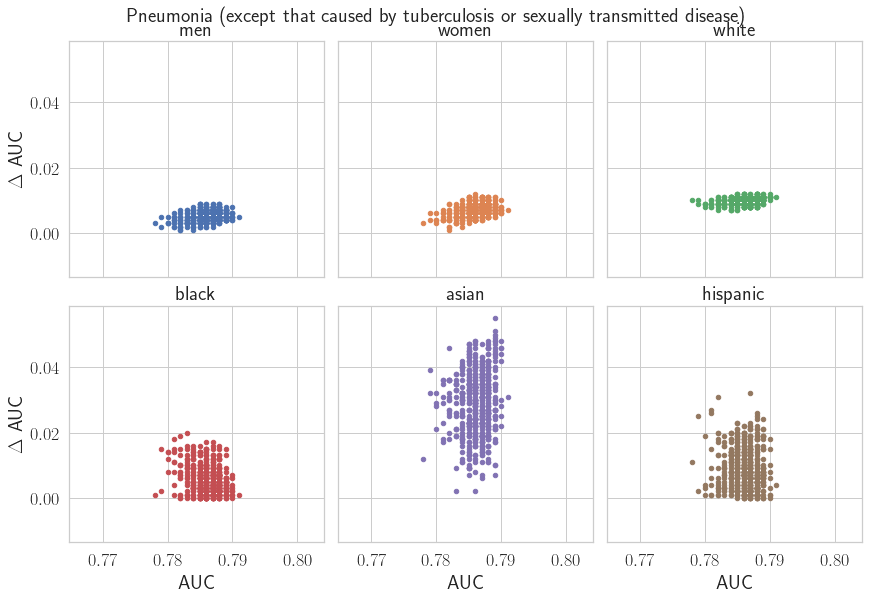

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc', 'ptcbtostd', 'rfia']


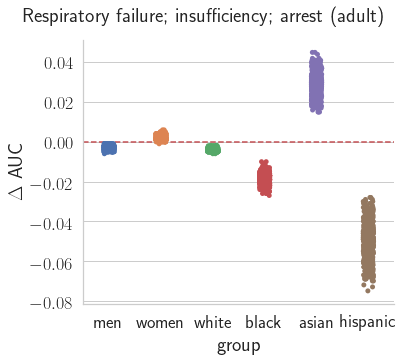

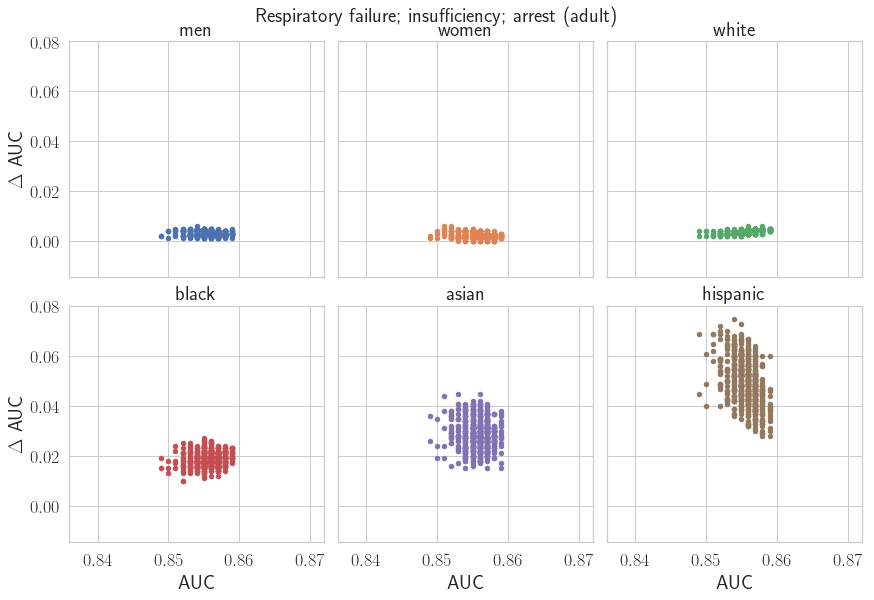

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc', 'ptcbtostd', 'rfia', 'sil']


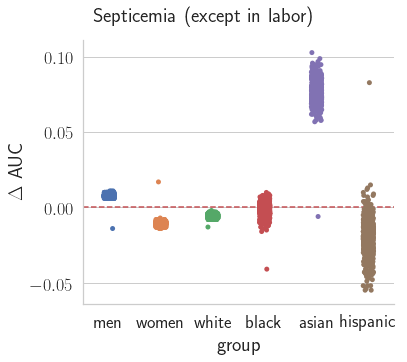

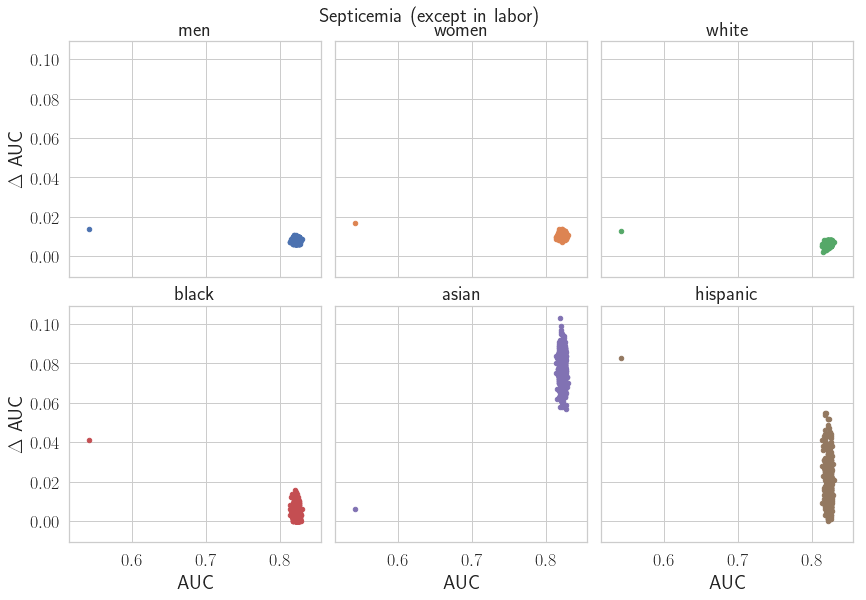

['ihm', 'aaurf', 'acd', 'ami', 'cd', 'ckd', 'copdab', 'cospomc', 'cd-2', 'chfn', 'caaohd', 'dmwc', 'dmwc-2', 'dolm', 'eh', 'faed', 'gh', 'hwcash', 'old', 'olrd', 'ourd', 'pppc', 'ptcbtostd', 'rfia', 'sil', 's']


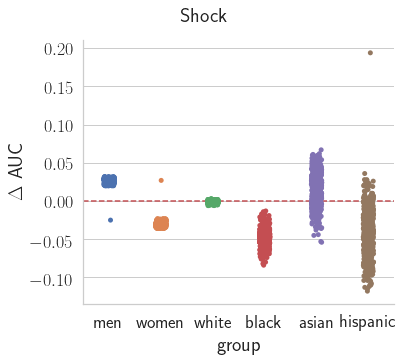

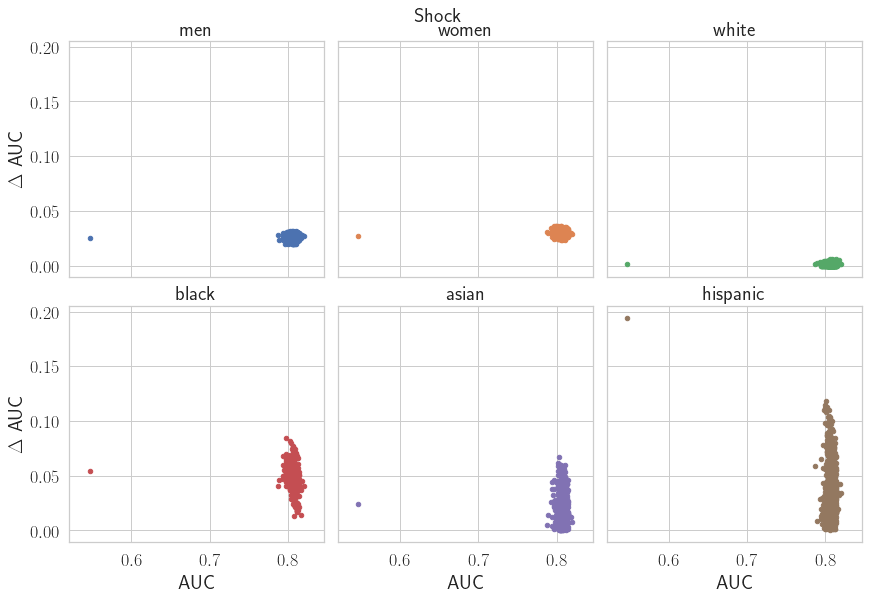

dolm_clinicalmulti-bert-pool_auroc.csv not found...


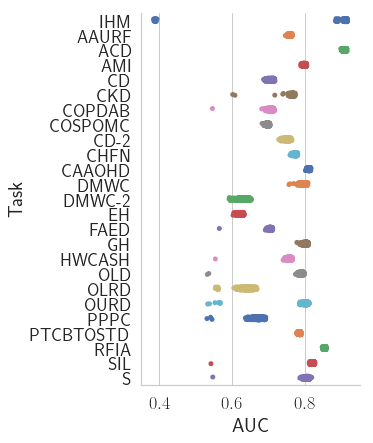

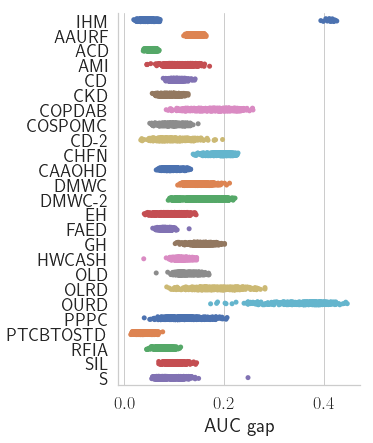

<Figure size 432x288 with 0 Axes>

In [12]:
OUTPUT_PATH=BASE_PATH+"/DATA/multiClinicalBERT/"
#Run tasks
CLASSIFIER="torch"
MODEL="CLINICALMULTI-BERT-POOL"
# run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, reset=True, 
#             metric=METRIC, tuning=False, mini_tasks=True)
plot_tasks(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False,  metric=METRIC)
plot_summary(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False,  metric=METRIC)

In [ ]:
#Run tasks
CLASSIFIER="torch"
OUTPUT_PATH=BASE_PATH+"/DATA/results_newrun/"
MODEL="CLINICALBERT-POOL"
# run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, reset=True, 
#            metric=TUNE_METRIC, tuning=False, mini_tasks=True)
plot_tasks(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False,  metric=METRIC)
# plot_summary(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False,  metric=METRIC)

In [ ]:
# RESULTS_PATH = BASE_PATH+"/DATA/results_clinical_GRID/"
# MODEL="CLINICALBERT-POOL"
# TUNE_METRIC="auroc"
# plot_gridsearches(INPUT_PATH+"tasks.txt", RESULTS_PATH, MODEL, False, TUNE_METRIC, subgroups=False) 